# Setup/Imports

In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import scipy.stats
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator

from sklearn.metrics import r2_score
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1,
                            allow_soft_placement=True,
                            device_count={'CPU': 1,
                                          'GPU': 0})
session = tf.Session(config=config)
K.set_session(session)


In [3]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

# Analysis

In [4]:
"""This is the one for the paper as of 5/20"""
file_path = '/projects/EKOLEMEN/profile_predictor/run_results_03_10/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5'


#file_path = '/projects/EKOLEMEN/profile_predictor/run_results_06_29/model-conv2d_profiles-dens-temp-q_EFIT02-rotation-press_EFIT02_act-target_density-pinj-tinj-curr_target_29Jun20-23-56_Scenario-835.h5'

#file_path = '/projects/EKOLEMEN/profile_predictor/run_results_time_scan/model-conv2d_profiles-dens-temp-rotation-q_EFIT01-press_EFIT01_act-target_density-pinj-tinj-curr_target-bt_22Aug20-07-05_Scenario-118.h5'
#file_path= '/projects/EKOLEMEN/profile_predictor/run_results_campaign_year/model-conv2d_profiles-dens-temp-rotation-q_EFIT01-press_EFIT01_act-target_density-pinj-tinj-curr_target-bt_10Oct20-19-33_Scenario-19.h5'

# base_path = os.path.expanduser('~/run_results_02_13/')
# model_path = 'model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_15Feb20-20-16_Scenario-62.h5'
# file_path = base_path + model_path


model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5
loaded dict: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl
with parameters: dict_keys(['model_type', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'sample_weightin', 'scalar_input_names', 'std_activation', 'batch_size', 'process_data', 'predict_deltas', 'epochs', 'loss_function', 'actuator_names', 'profile_downsample', 'sample_weighting', 'loss_function_kwargs', 'flattop_only', 'raw_data_path', 'invert_q', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'val_idx', 'nshots', 'excluded_shots', 'lookbac

In [5]:
orig_data_path = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
orig_data_path = scenario['raw_data_path']
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(orig_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      scenario['train_frac'],
                                                      scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      invert_q=scenario.setdefault('invert_q',False),
                                                      val_idx = 0, #scenario['val_idx'],
                                                      uncertainties=False)
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])
valdata = helpers.normalization.renormalize(helpers.normalization.denormalize(valdata.copy(),normalization_dict),scenario['normalization_dict'])

Loading
Signals: curr_target, dens, density_estimate, kappa_EFIT01, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  6378
Number of shots used:  6378
Total number of timesteps:  671222
Shots with Complete NaN: 
454582 samples total
Removing ECH
Removed 194246 samples
260336 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 52091 samples
208245 samples remaining
Removing weird I-coils
Removed 46528 samples
161717 samples remaining
Removing NaN
Removed 0 samples
161717 samples remaining
Removing dudtrip
Removed 9571 samples
152146 samples remaining
152146 samples remaining after pruning


Denormalizing:  29%|##9       | 7/24 [00:00<00:00, 68.13it/s]

Total number of samples:  152146
Number of training samples:  137014
Number of validation samples:  15132


Normalizing: 100%|##########| 24/24 [00:00<00:00, 93.42it/s] 


In [6]:
# import importlib
# importlib.reload(helpers.data_generator)

# orig_data_path = '/scratch/gpfs/jabbate/full_data_with_error/joe_test.pkl' 
# _,_,_ = helpers.data_generator.process_data(orig_data_path,
#                                                       scenario['sig_names'],
#                                                       scenario['normalization_method'],
#                                                       scenario['window_length'],
#                                                       scenario['window_overlap'],
#                                                       scenario['lookbacks'],
#                                                       scenario['lookahead'],
#                                                       scenario['sample_step'],
#                                                       scenario['uniform_normalization'],
#                                                       scenario['train_frac'],
#                                                       scenario['val_frac'],
#                                                       scenario['nshots'],
#                                                       2, #scenario['verbose']
#                                                       scenario['flattop_only'],
#                                                       randomize=False,
#                                                       pruning_functions=scenario['pruning_functions'],
#                                                       excluded_shots = scenario['excluded_shots'],
#                                                       delta_sigs = [],
#                                                       invert_q=scenario.setdefault('invert_q',False),
#                                                       val_idx = 0, #scenario['val_idx'],
#                                                       uncertainties=False)

In [7]:
print('num train shots: ',len(np.unique(traindata['shotnum'])))
print('num test shots: ',len(np.unique(valdata['shotnum'])))

num train shots:  3532
num test shots:  389


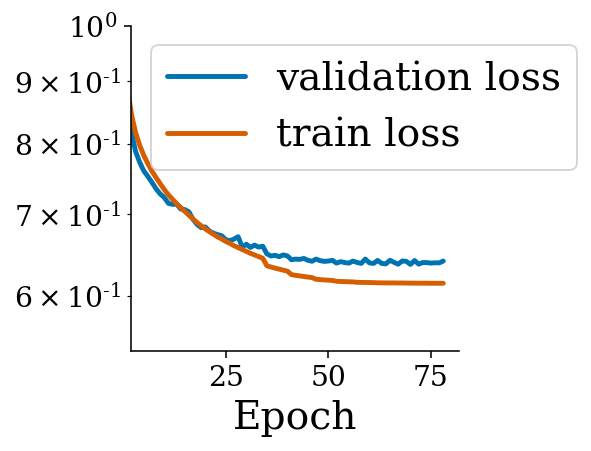

In [8]:
fig, ax = plt.subplots(figsize=(3,3))
ax.semilogy(scenario['history']['val_loss'],label='validation loss')
ax.semilogy(scenario['history']['loss'],label='train loss')
ax.set_xlim((2,None))
ax.set_ylim((None,1))
ax.set_xlabel('Epoch', size=20)
ax.legend(fontsize=20)
#plt.ylim(0,.1)
# fig.savefig('training.png')

In [9]:
profiles=scenario['target_profile_names']
psi = np.linspace(0,1,scenario['profile_length'])

In [10]:
with open('/projects/EKOLEMEN/profile_predictor/full_pca_fitters.pkl','rb') as f:
    full_pca_fitters = pickle.load(f, encoding='latin1')
with open('/projects/EKOLEMEN/profile_predictor/delta_pca_fitters.pkl','rb') as f:
    delta_pca_fitters = pickle.load(f, encoding='latin1')

In [11]:
profiles=['temp','dens','rotation']

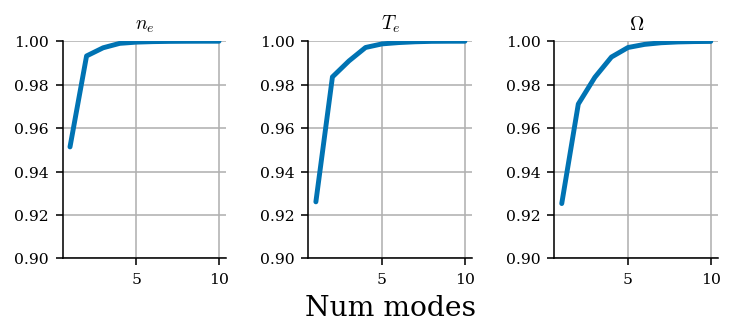

In [12]:
"""plot explained variance"""

ylabels = ['$n_e$','$T_e$','$\Omega$','$\iota$','$P$']

fig, axes = plt.subplots(1,len(profiles),sharey=False,figsize=(6,2))
for j,profile in enumerate(profiles):
    pca=full_pca_fitters[profile]
    ax = axes[j]
    
    ax.plot(np.arange(1,pca.n_components+1),np.cumsum(pca.explained_variance_ratio_))
    ax.set_title(ylabels[j],size=10)
    #ax.set_ylabel(ylabels[j],size=10)
    ax.grid()
    ax.set_ylim((.9,1))
    if j==1:
        ax.set_xlabel('Num modes')
    ax.tick_params(axis='both', which='both', labelsize=8)

#fig.suptitle('Explained Variance (full profiles)', size=12)
plt.subplots_adjust(wspace=.5)
# fig.savefig('explained_variance.png')

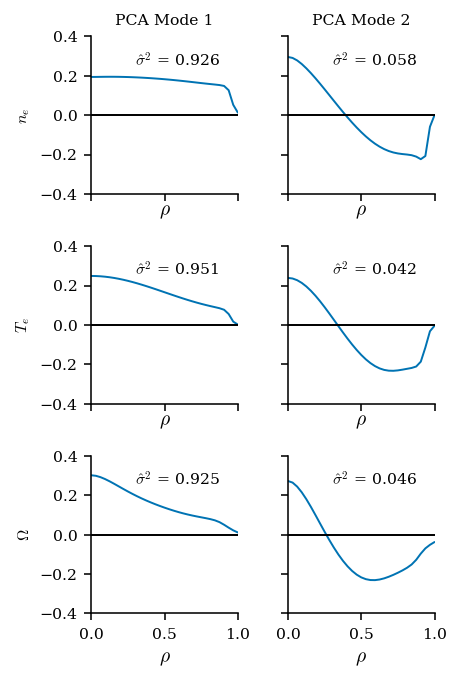

In [13]:
"""plot full pca modes"""

ncols = 2
nrows = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(3.5,5))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))


labels = ['$n_e$','$T_e$','$\Omega$','$\iota$','$P$']
profiles = ['dens','temp','rotation']#,'rotation','q_EFIT02','press_EFIT02']
for i,profile in enumerate(profiles):
    pca=full_pca_fitters[profile]
    for j in range(ncols):
        ax= axes[i,j]
        ax.plot(psi,pca.components_[j],lw=1)
        ax.text(0.3,0.25,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca.explained_variance_ratio_[j]),fontsize=8)
        if j==0:
            ax.set_ylabel(labels[i], size=8)
        if i==0:
            ax.set_title('PCA Mode {}'.format(j+1), size=8)
        if i in [0,1,2]:
            ax.set_xlabel('$\\rho$',size=10)
        if i in [3,4]:
            ax.set_xlabel('$\psi$',size=10)
        ax.set_ylim(-.4,.4)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_xticks([0,.5,1])
        ax.set_xlim(0,1)

        ax.axhline(0,c='k',lw=1)
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
# fig.savefig('images/pca_modes.pdf')
# fig.savefig('images/pca_modes.png')

# Some helper functions

In [14]:
   
def scalarize_mean(arr, **kwargs):
    return np.mean(arr)

def scalarize_std(arr, **kwargs):
    return np.std(arr)

def scalarize_pca_1(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[2]
    return ret

def scalarize_pca_4(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[3]
    return ret

def scalarize_pca_5(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[4]
    return ret

def scalarize_pca_6(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[5]
    return ret

def find_bounds(true,pred,percentile=90):
    arr = np.concatenate([true,pred]).flatten()
  
    true_bounds=(np.percentile(true, 50-percentile/2),np.percentile(true, 50+percentile/2))
    pred_bounds=(np.percentile(pred, 50-percentile/2),np.percentile(pred, 50+percentile/2))
    return (np.maximum(true_bounds[0],pred_bounds[0]),np.minimum(true_bounds[1],pred_bounds[1]))

In [15]:
eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$',# ($10^{19}/m^3$)',
          'etemp': '$T_e$',# (keV)',
          'itemp': '$T_i$',# (keV)',
          'rotation':'$\Omega$',# (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}

In [16]:
"""make predictions"""

data_generator_batch = DataGenerator(valdata,
                                128, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                shuffle=False,
                                sample_weights = None) 

predictions_arr = model.predict_generator(data_generator_batch,verbose=1)

119/119 [==============================] - 392s 3s/step


In [17]:
data_generator = DataGenerator(valdata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                shuffle=False,
                                sample_weights = None)

In [18]:
"""get baseline error = predict constant, so just getting the target from the train generator"""

baseline = {sig:[] for sig in scenario['target_profile_names']}
full_profiles = {sig:[] for sig in scenario['target_profile_names']}

inp = {sig:[] for sig in scenario['target_profile_names']}
true = {sig:[] for sig in scenario['target_profile_names']}

shots = []
times = []
for i in range(len(data_generator_batch)):
    print("{}/{}".format(i+1,len(data_generator_batch)),end='\r')
    sample = data_generator_batch[i]
    shots.append(data_generator_batch.cur_shotnum[:,0])
    times.append(data_generator_batch.cur_times[:,-scenario['lookahead']-1])
    for sig in scenario['target_profile_names']:
        baseline[sig].append(sample[1]['target_'+sig])
        full_profiles[sig].append(sample[0]['input_'+sig].squeeze() + sample[1]['target_'+sig])
        
        inp[sig].append(sample[0]['input_'+sig].squeeze())
        true[sig].append(sample[0]['input_'+sig].squeeze() + sample[1]['target_'+sig])

In [19]:
"""reorganize"""

predictions = {sig: arr for sig, arr in zip(scenario['target_profile_names'],predictions_arr)}
baseline = {sig:np.concatenate(baseline[sig],axis=0).squeeze() for sig in scenario['target_profile_names']}
full_profiles = {sig:np.concatenate(full_profiles[sig],axis=0).squeeze() for sig in scenario['target_profile_names']}
inp = {sig:np.concatenate(inp[sig],axis=0).squeeze() for sig in scenario['target_profile_names']}
true = {sig:np.concatenate(true[sig],axis=0).squeeze() for sig in scenario['target_profile_names']}
shots = np.concatenate(shots,axis=0)
times = np.concatenate(times,axis=0)

In [20]:
denormed_predictions={sig: helpers.normalization.denormalize_arr(predictions[sig]+inp[sig],scenario['normalization_dict'][sig]) for sig in scenario['target_profile_names']}
denormed_inp={sig: helpers.normalization.denormalize_arr(inp[sig],scenario['normalization_dict'][sig]) for sig in scenario['target_profile_names']}
denormed_true={sig: helpers.normalization.denormalize_arr(true[sig],scenario['normalization_dict'][sig]) for sig in scenario['target_profile_names']}

In [21]:
def sigma(inp,true,prediction):
    eps=prediction-true
    
    num=np.linalg.norm(eps,axis=-1)
    denom=np.linalg.norm(true,axis=-1)
    
    return num/denom

def mae(inp,true,prediction):
    eps=prediction-true
    return np.median(np.abs(eps))

/home/jabbate/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  import sys


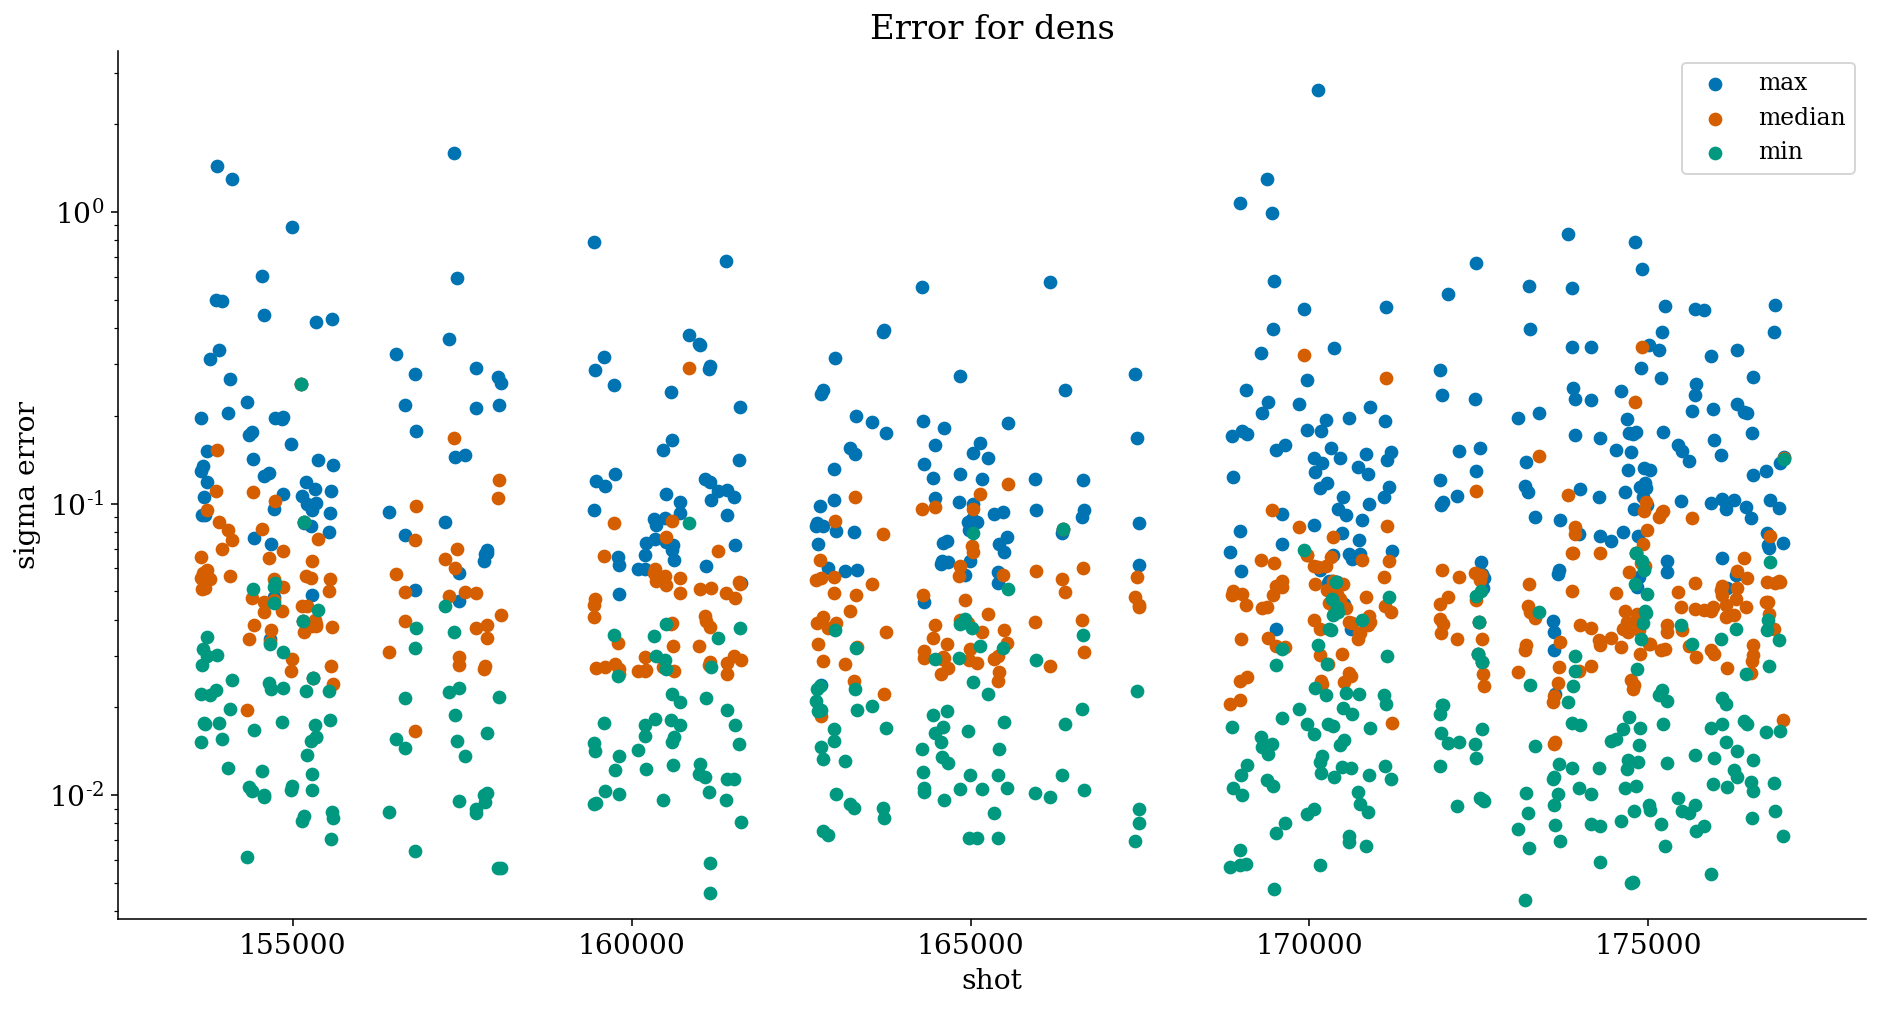

In [22]:
sig='dens'
unique_shots=np.unique(shots)
error_for_shot=[]
min_error_for_shot=[]
max_error_for_shot=[]
errors=np.array([sigma(denormed_inp[sig][ind],
                  denormed_true[sig][ind],
                  denormed_predictions[sig][ind]) for ind in range(len(denormed_inp[sig]))])

for shot in unique_shots:
    inds=np.where(shots==shot)[0]
    error_for_shot.append(np.nanmedian(errors[inds]))
    min_error_for_shot.append(np.nanmin(errors[inds]))
    max_error_for_shot.append(np.nanmax(errors[inds]))

plt.title('Error for {}'.format(sig))
plt.scatter(unique_shots,max_error_for_shot,label='max')
plt.scatter(unique_shots,error_for_shot,label='median')
plt.scatter(unique_shots,min_error_for_shot,label='min')
plt.xlabel('shot')
plt.ylabel('sigma error')
plt.yscale('log')
plt.legend()
plt.show()

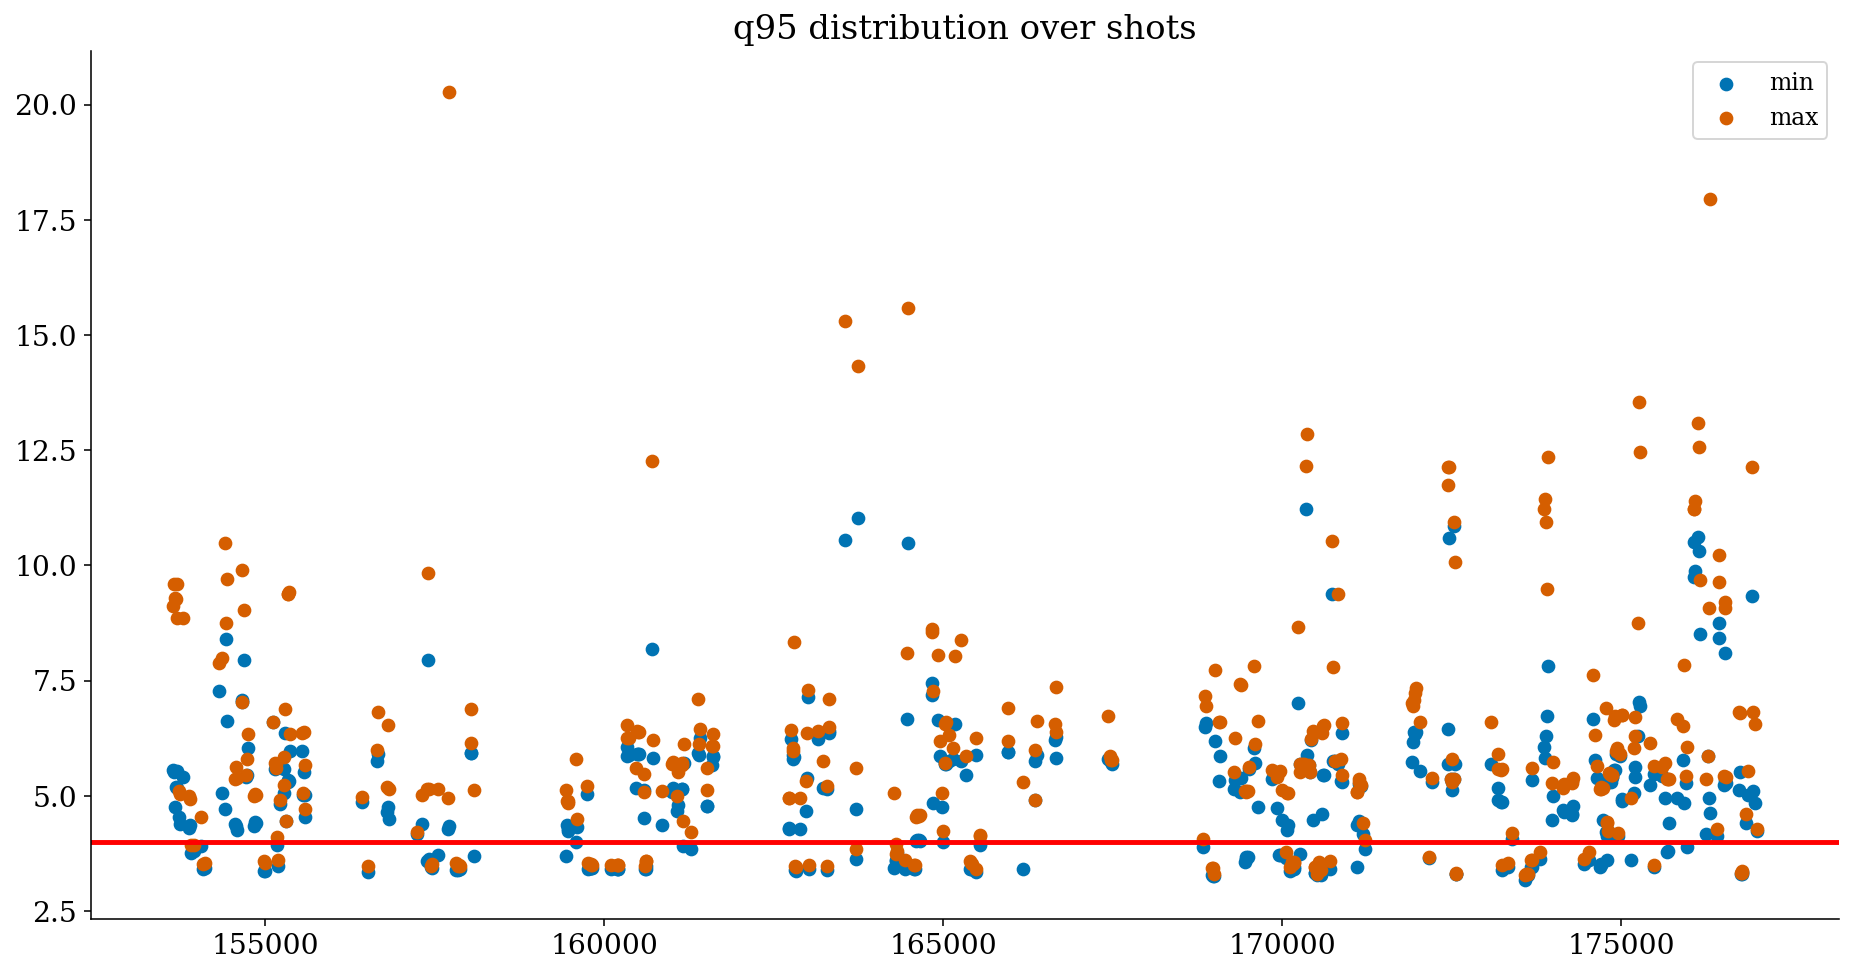

In [23]:
sig='q_EFIT01'
def get_95(inp):
    return 1/inp[int(.95*len(psi))]
unique_shots=np.unique(shots)
error_for_shot=[]
min_error_for_shot=[]
max_error_for_shot=[]
errors=np.array([get_95(denormed_inp[sig][ind]) for ind in range(len(denormed_inp[sig]))])

for shot in unique_shots:
    inds=np.where(shots==shot)[0]
    error_for_shot.append(np.nanmedian(errors[inds]))
    min_error_for_shot.append(np.nanmin(errors[inds]))
    max_error_for_shot.append(np.nanmax(errors[inds]))

plt.title('q95 distribution over shots')
plt.scatter(unique_shots,min_error_for_shot,label='min')
#plt.scatter(unique_shots,error_for_shot,label='median')
plt.scatter(unique_shots,max_error_for_shot,label='max')
plt.legend()
plt.axhline(4,c='r')
plt.show()

/home/jabbate/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jabbate/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


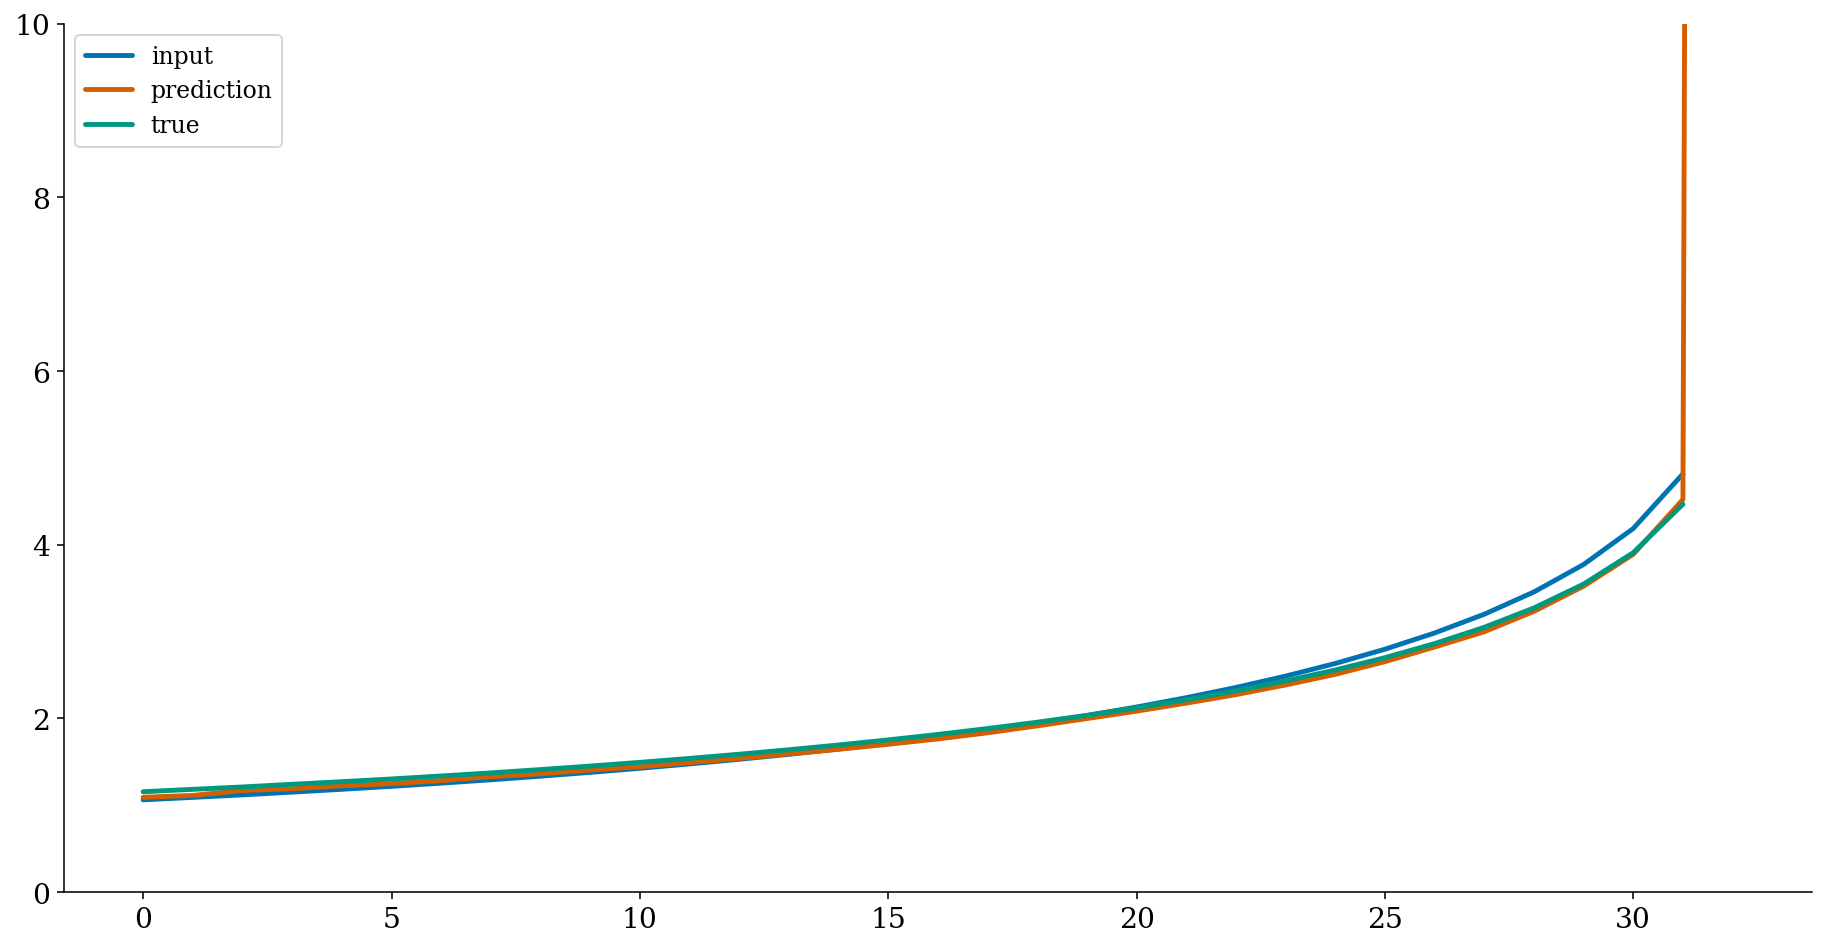

In [24]:
# ind 521 to 527 for shot 154110
ind=9554
plt.plot(1/denormed_inp['q_EFIT01'][ind],label="input")
plt.plot(1/denormed_predictions['q_EFIT01'][ind],label="prediction")
plt.plot(1/denormed_true['q_EFIT01'][ind],label="true")
plt.ylim((0,10))
plt.legend()
plt.show()

In [31]:
psi[int(len(psi)*.91)]

0.9375

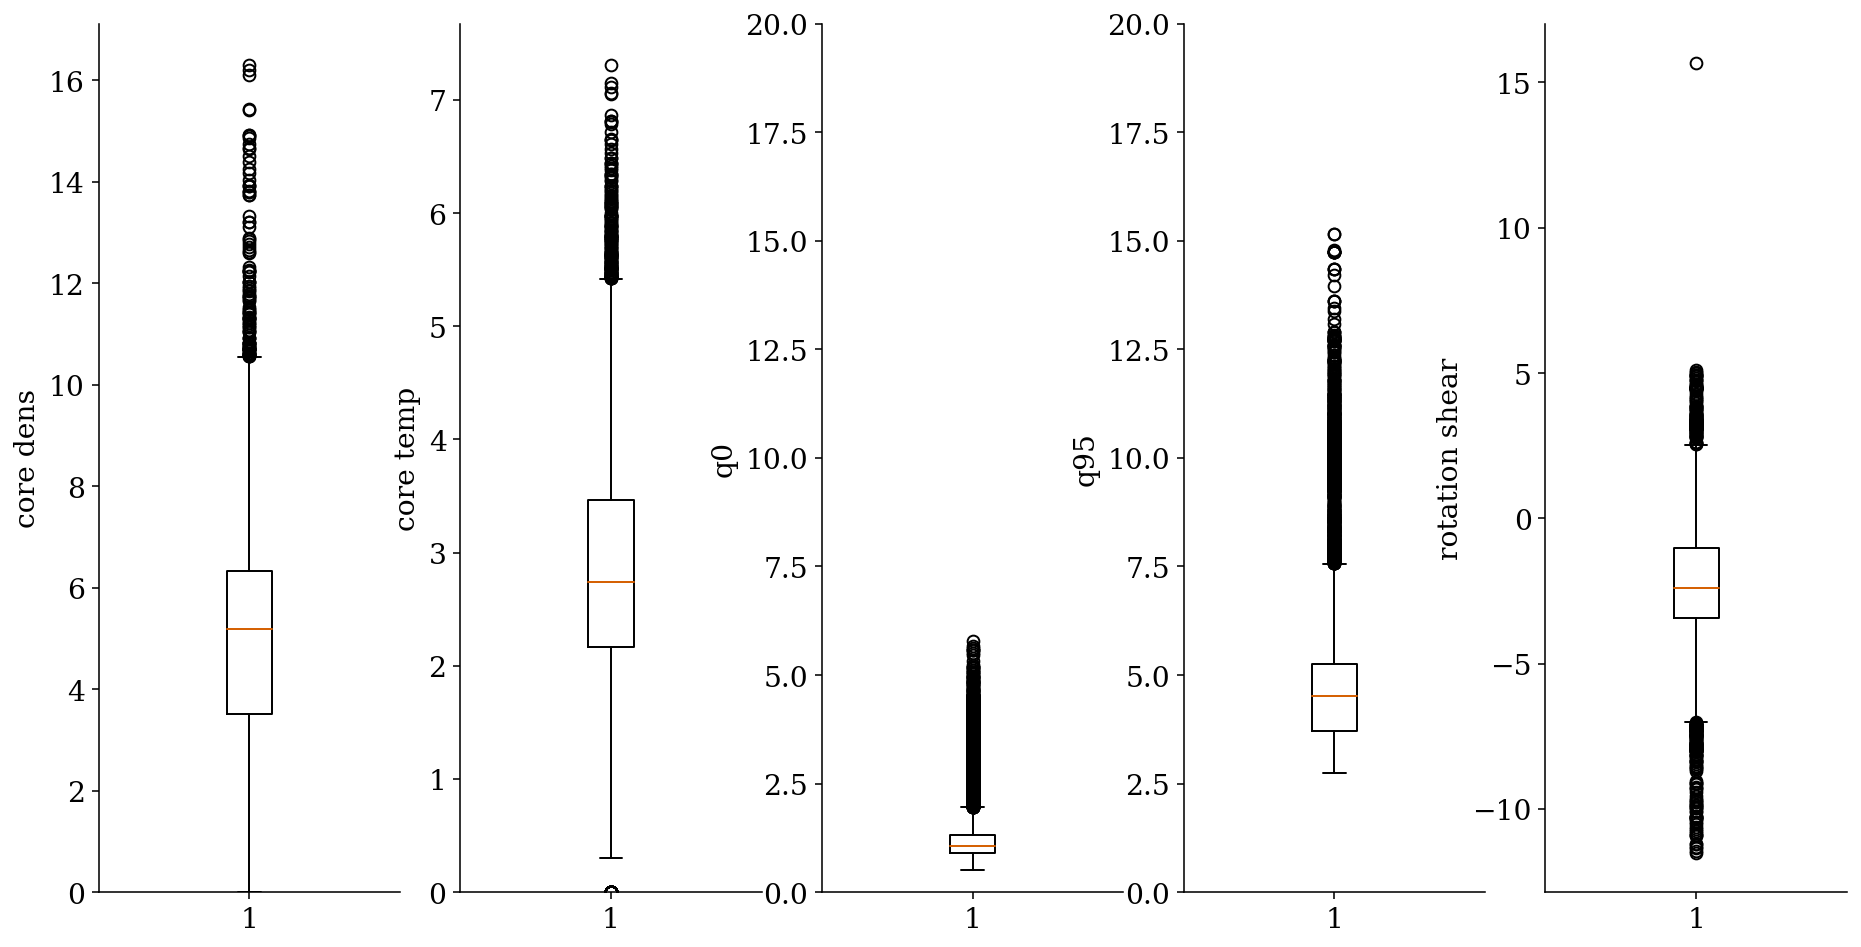

In [33]:
names=['core dens', 'core temp','q0','q95','rotation shear']
values=[]
values.append(denormed_inp['dens'][:,0])
values.append(denormed_inp['temp'][:,0])
values.append(1/denormed_inp['q_EFIT01'][:,0])
values.append(1/denormed_inp['q_EFIT01'][:,-3])
values.append(np.median(np.diff(denormed_inp['rotation'],axis=1),axis=1))
fig,axes=plt.subplots(nrows=1,ncols=len(names))
for i in range(len(names)):
    axes[i].boxplot(values[i])
    axes[i].set_ylabel(names[i])
    max_y=None
    if 'q' in names[i]:
        max_y=20
    min_y=0
    if 'rotation' in names[i]:
        min_y=None
    axes[i].set_ylim((min_y,max_y))

In [37]:
from sklearn.cluster import KMeans
values_arr=np.array([arr for arr in values]).T
kmeans = KMeans().fit(values_arr)
classes=kmeans.predict(values_arr)
from matplotlib import cm
my_map=cm.get_cmap('viridis',8)
colors=[my_map.colors[this_class] for this_class in classes]

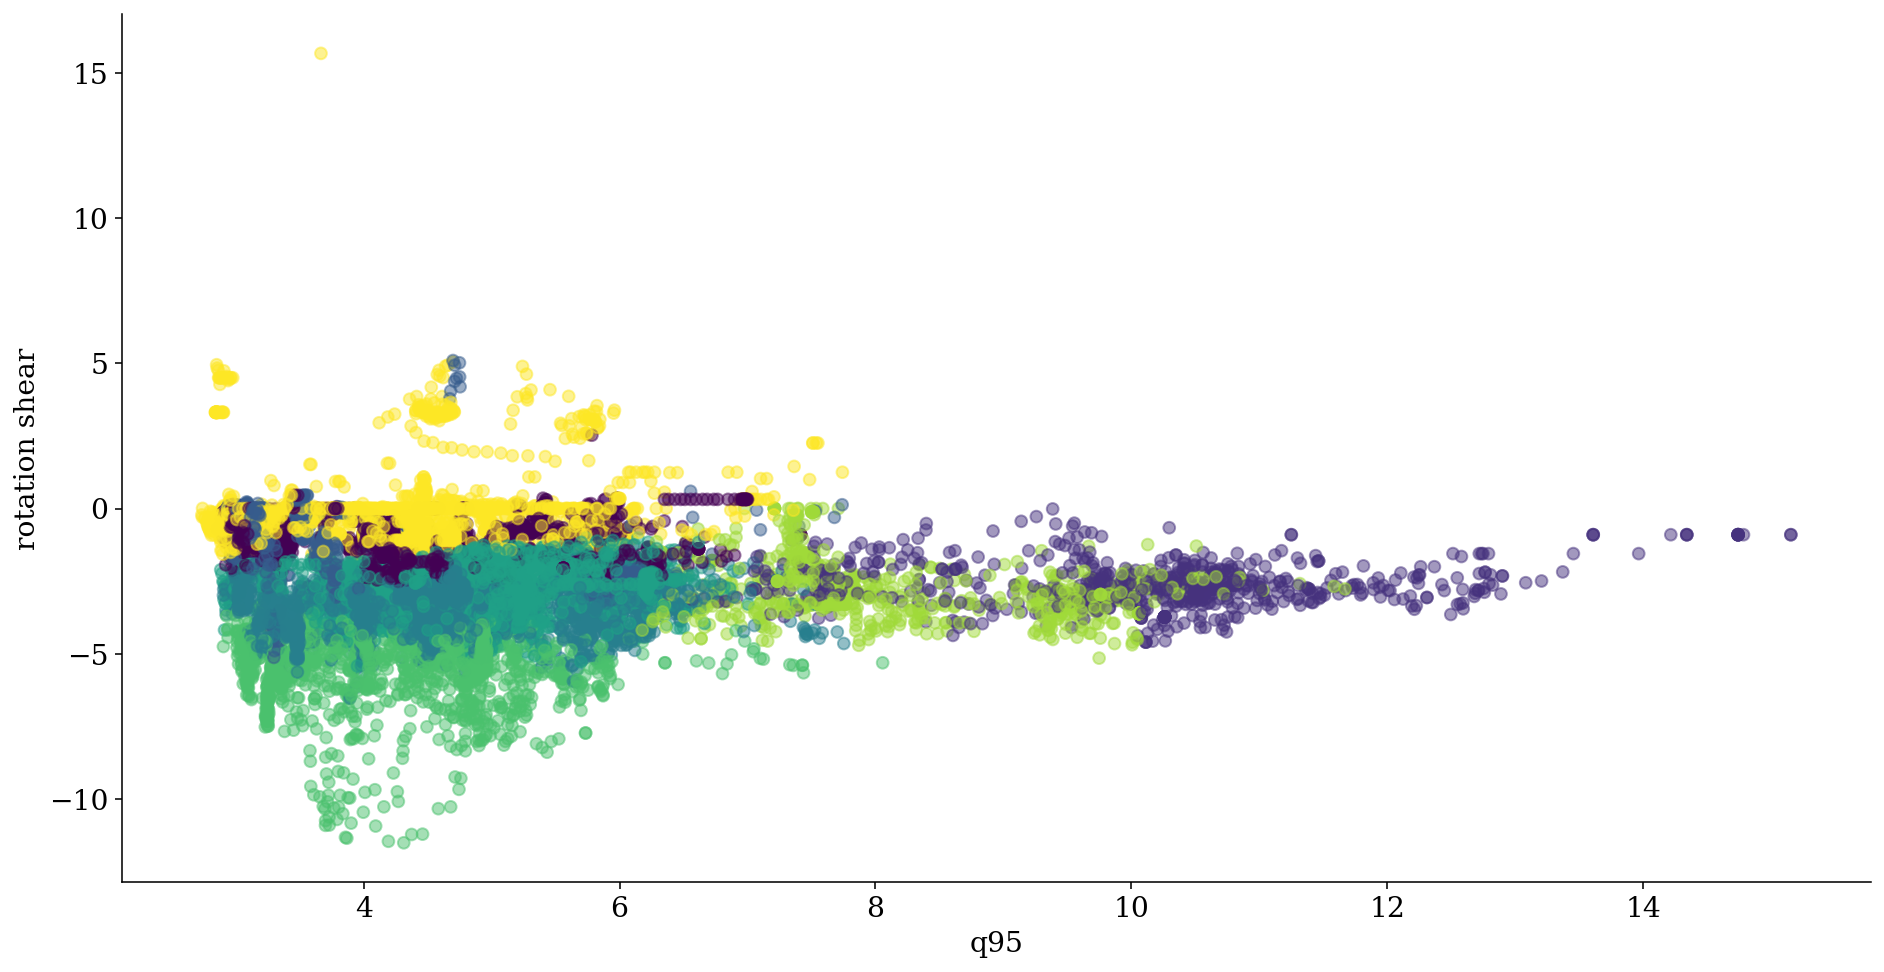

In [63]:
first_ind=3
second_ind=4
plt.scatter(values[first_ind],
            values[second_ind],
            color=colors,
            alpha=.5)
plt.xlabel(names[first_ind])
plt.ylabel(names[second_ind])
#plt.xlim((0,20))
#plt.ylim((0,20))
plt.show()

ValueError: 'color' kwarg must be an mpl color spec or sequence of color specs.
For a sequence of values to be color-mapped, use the 'c' argument instead.

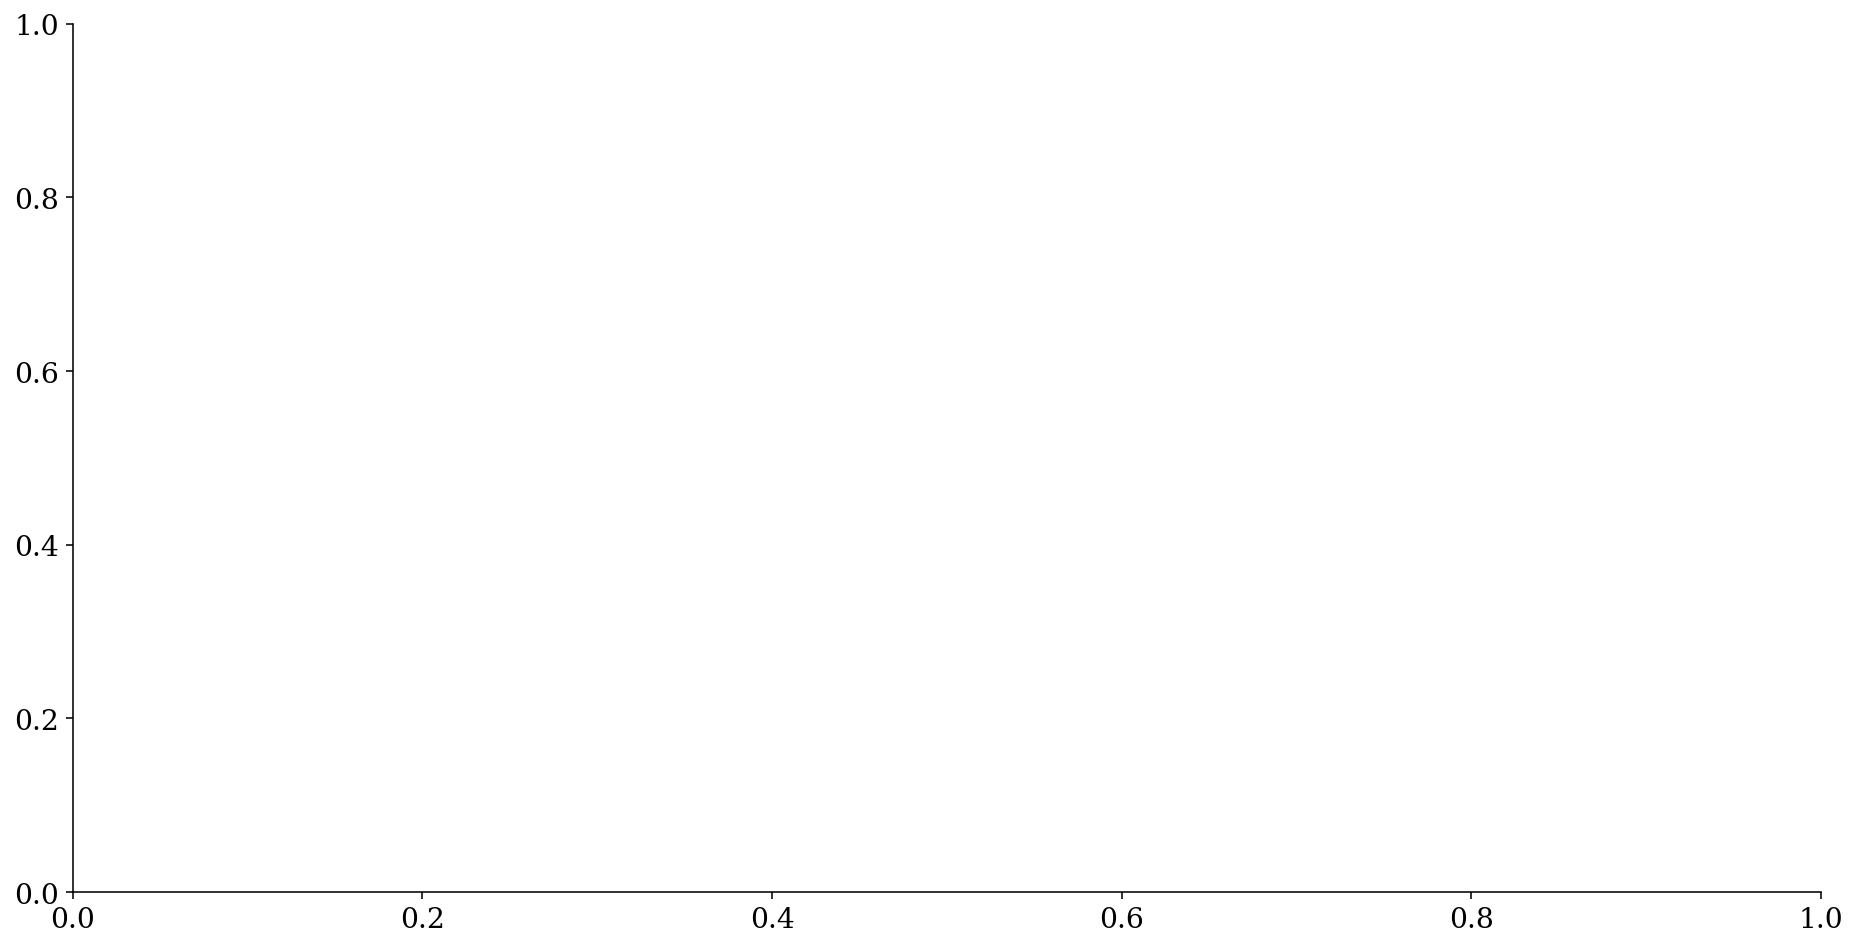

In [44]:
from matplotlib import cm

first_ind=0
second_ind=-1
plt.scatter(values[first_ind],
            values[second_ind],
            color=my_map[colors],
            alpha=1)
plt.xlabel(names[first_ind])
plt.ylabel(names[second_ind])
#plt.xlim((0,20))
#plt.ylim((0,20))
plt.show()

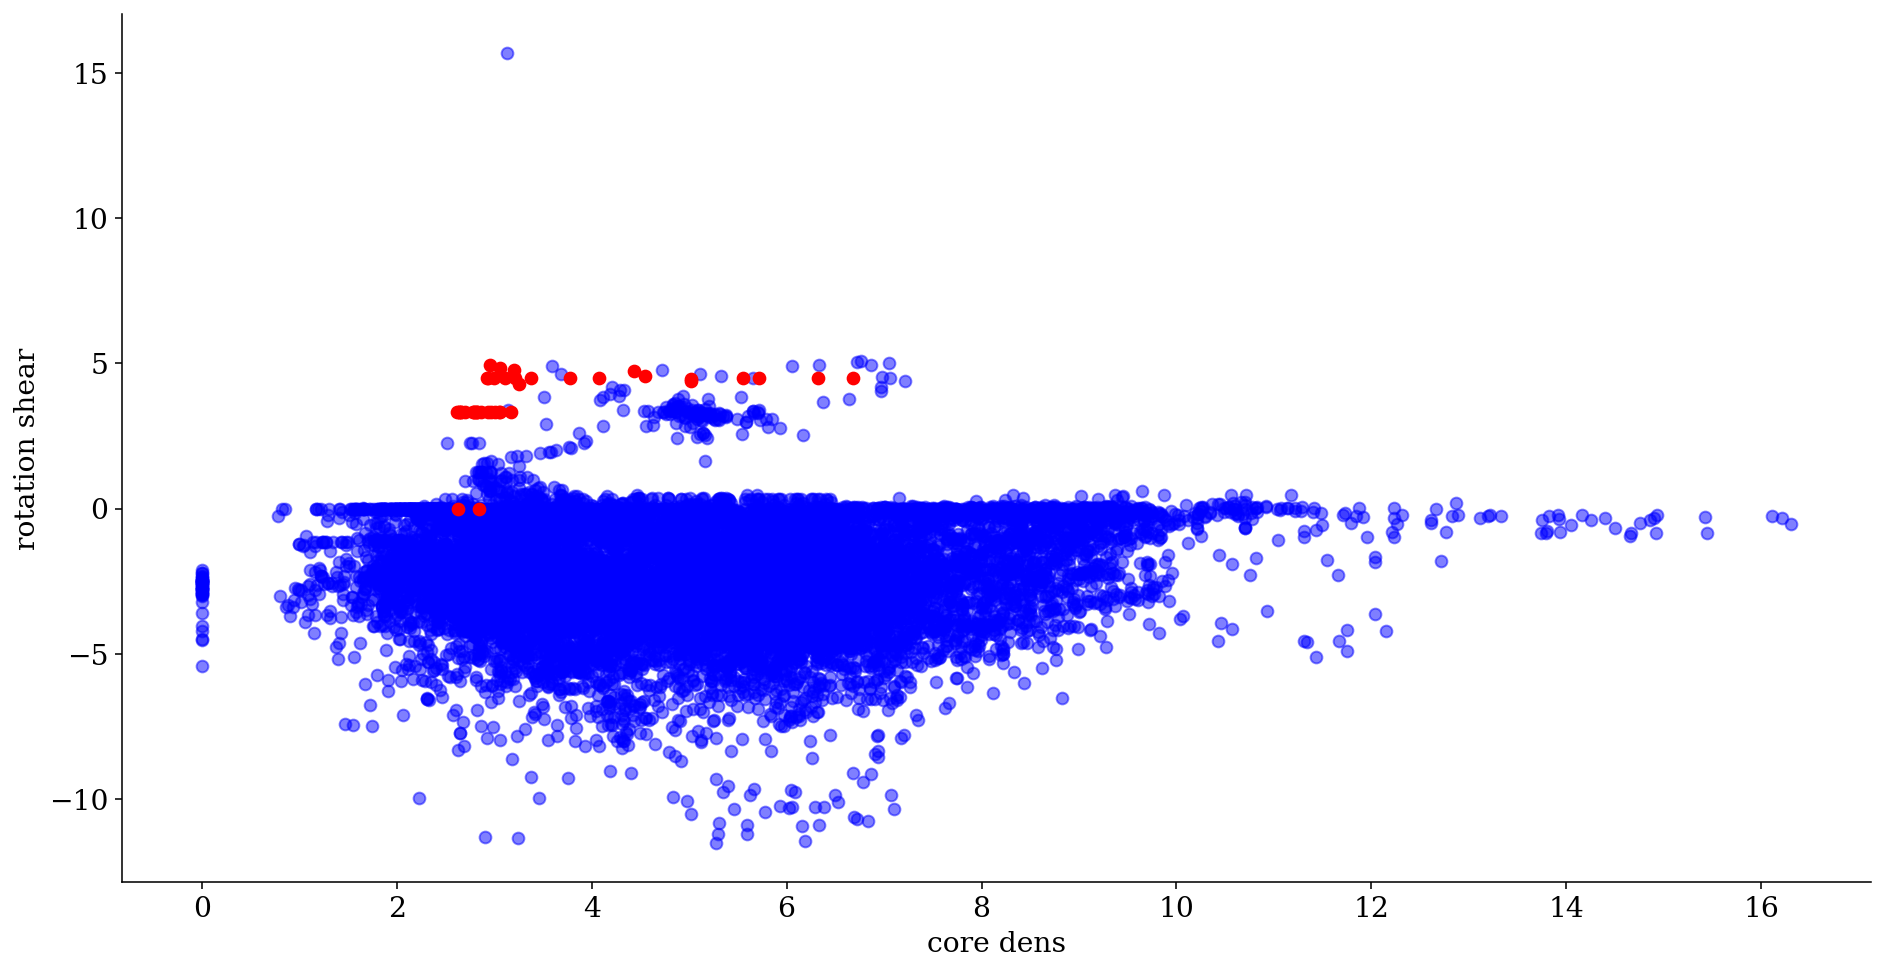

In [86]:
first_ind=0
second_ind=-1
my_shot_inds=shots==156520
plt.scatter(values[first_ind][~my_shot_inds],
            values[second_ind][~my_shot_inds],
            color='b',
            alpha=.5)
plt.scatter(values[first_ind][my_shot_inds],
            values[second_ind][my_shot_inds],
            color='r',
            alpha=1)
plt.xlabel(names[first_ind])
plt.ylabel(names[second_ind])
#plt.xlim((0,20))
#plt.ylim((0,20))
plt.show()

In [85]:
print(len(unique_shots))

389


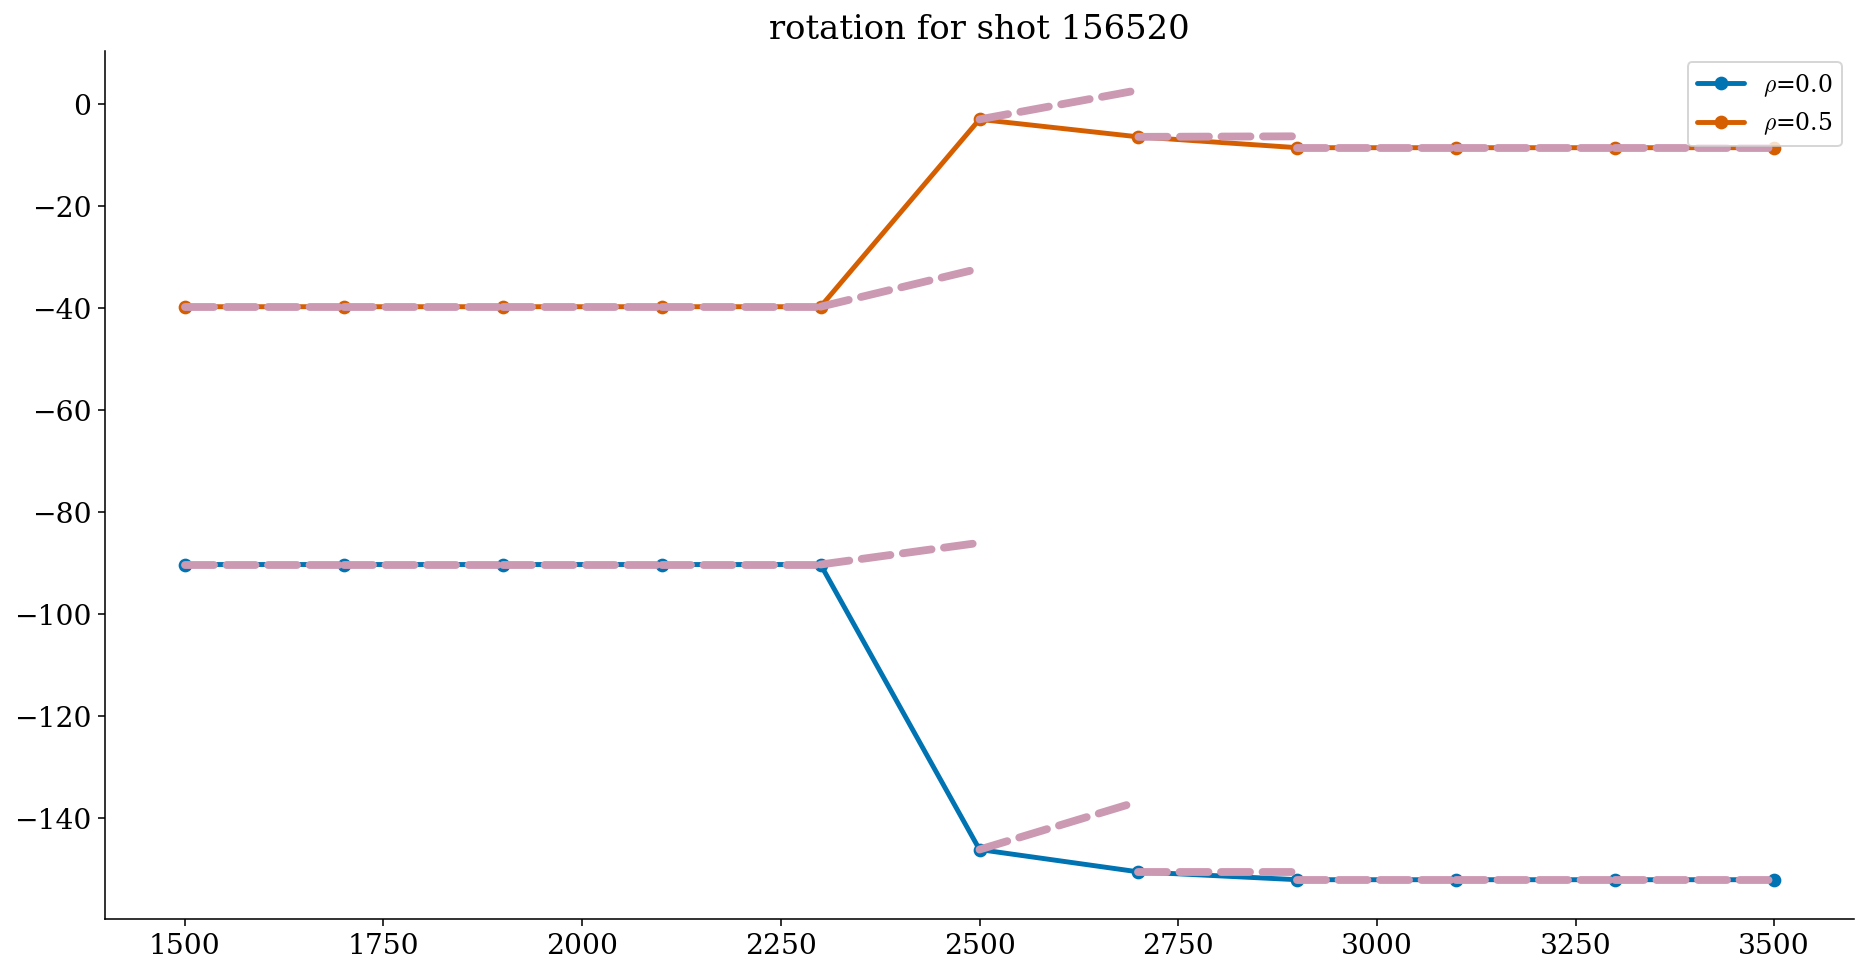

In [88]:
ind=np.argsort(error_for_shot)[17] #-8 is 157380

# 159590 is the QH shot in Paz Soldan's database
# 156520 is the reverse shear shot
shot=156520 #unique_shots[ind]
inds = np.where(shots==shot)[0][::scenario['lookahead']]
sig='rotation'

psi_inds=[0,int(.5*len(psi))] #,-1

for i,psi_ind in enumerate(psi_inds):
    scalarize_function=lambda arr: arr[psi_ind]
    plt.plot([times[ind] for ind in inds], 
             [scalarize_function(denormed_true[sig][ind]) for ind in inds],
             color=colorblind_colors[i],
            marker='o',
            label=r'$\rho$={}'.format(psi[psi_inds[i]]))
    for ind in inds[1:]:  
        plt.plot([times[ind-scenario['lookahead']],
                  times[ind]], 
                 [scalarize_function(denormed_true[sig][ind-scenario['lookahead']]),
                  scalarize_function(denormed_predictions[sig][ind])],
                 color=colorblind_colors[-2],
                linestyle='--',
                linewidth=4)
plt.title('{} for shot {}'.format(sig,int(shot)))
plt.ylim((None,None))
plt.legend()
plt.show()

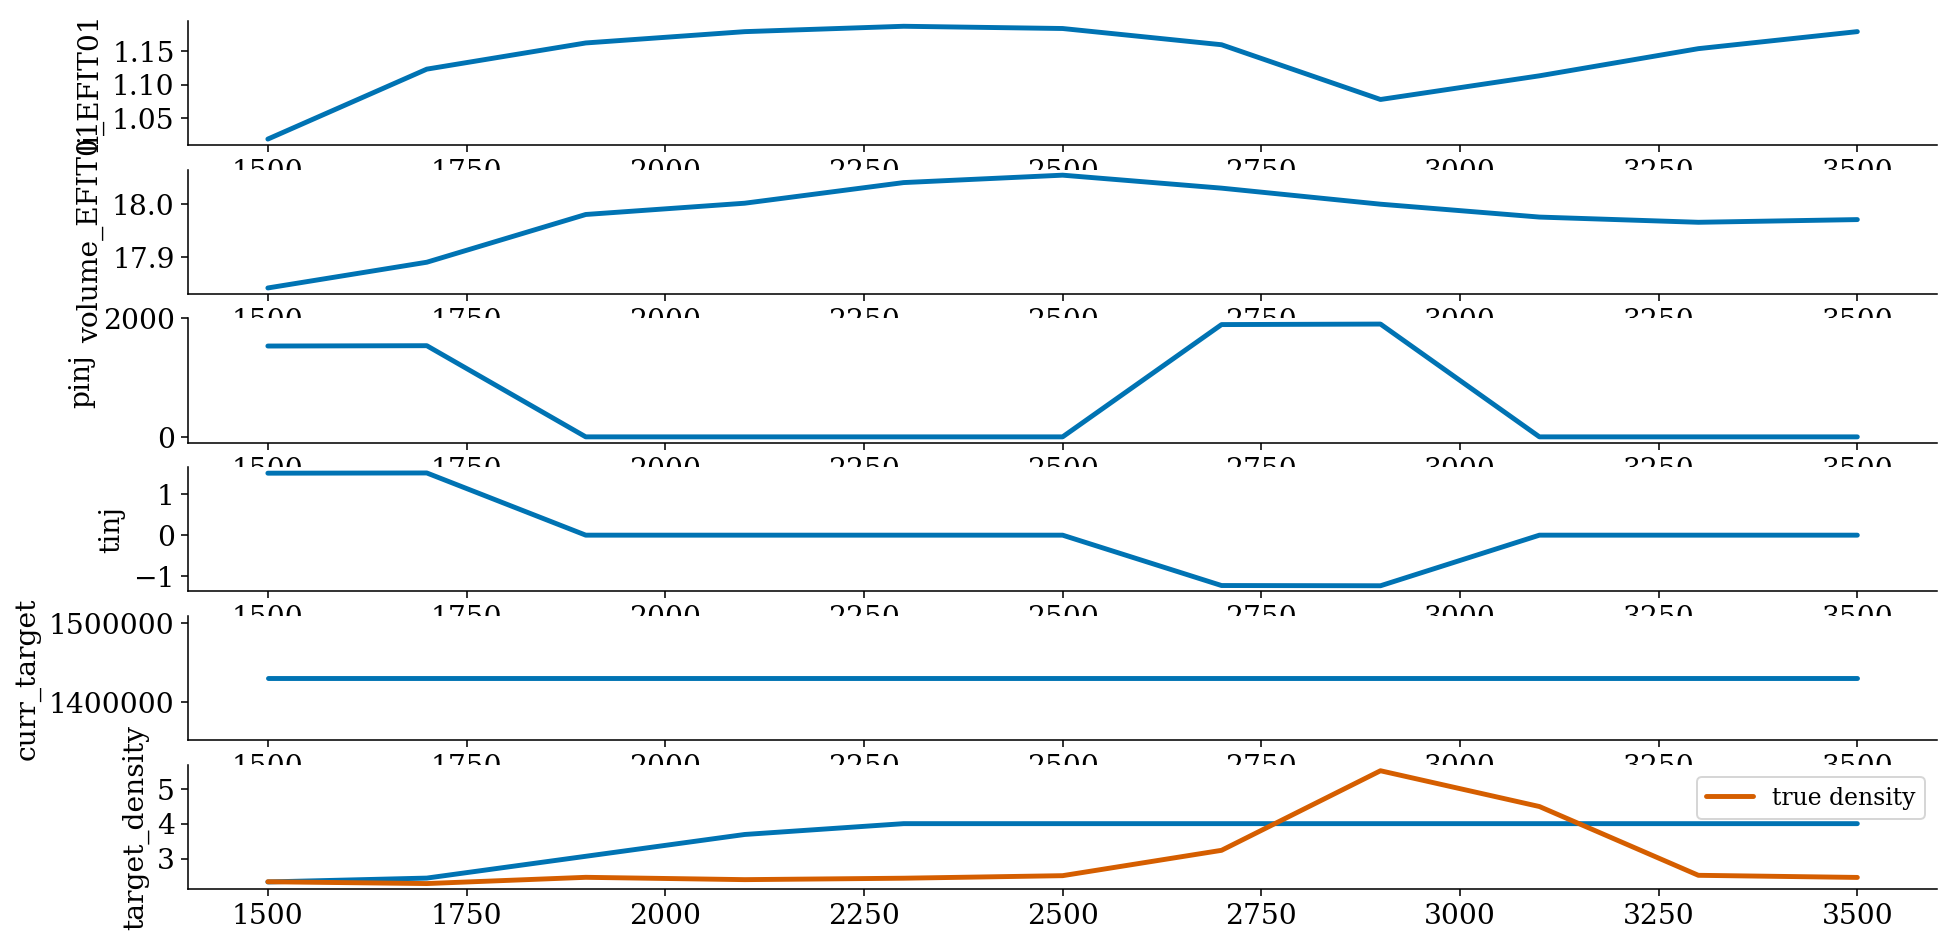

In [91]:
actuator_names=['li_EFIT01','volume_EFIT01','pinj','tinj','curr_target','target_density']
add_on=['','','past_','past_','past_','past_']
fig,axes=plt.subplots(len(actuator_names))
axes=np.atleast_1d(axes)
for i,actuator_name in enumerate(actuator_names):
    actuator_sequence=[]
    for ind in inds:
        actuator_sequence.append(data_generator[ind][0]['input_{}{}'.format(add_on[i],actuator_name)][0][-1])
    actuator_sequence=np.array(actuator_sequence)
    denormalized_actuator_sequence=helpers.normalization.denormalize_arr(actuator_sequence,scenario['normalization_dict'][actuator_name])
    axes[i].plot(times[inds],denormalized_actuator_sequence)
    if actuator_name=='target_density':
        actuator_sequence=[]
        for ind in inds:
            actuator_sequence.append(data_generator[ind][0]['input_{}'.format('density_estimate')][0][-1])
        actuator_sequence=np.array(actuator_sequence)
        denormalized_actuator_sequence=helpers.normalization.denormalize_arr(actuator_sequence,scenario['normalization_dict']['density_estimate'])
        axes[i].plot(times[inds],denormalized_actuator_sequence,label='true density')
        axes[i].legend()
    axes[i].set_ylabel(actuator_name)
    #axes[i].set_ylim((0,None))

In [22]:
"""get PCA coeffs"""

fitter = full_pca_fitters
scalarize_functions = [scalarize_mean, scalarize_pca_1,scalarize_pca_2]
scalarize_function_names = [fun.__name__[10:] for fun in scalarize_functions]
profiles = ['temp','dens','rotation'] #scenario['target_profile_names']

num_samples = len(baseline[list(baseline.keys())[0]])

#all_true_delta = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}
#all_predicted_delta = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}
all_true = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}
all_predicted = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}
all_inp = {sig:{metric:np.zeros(num_samples) for metric in scalarize_function_names} for sig in profiles}

n=1
nmax = len(profiles)*num_samples*len(scalarize_functions)
for j,profile in enumerate(profiles):
    for k in range(num_samples):
        for i,scalarize in enumerate(scalarize_functions):
            #all_true_delta[profile][scalarize_function_names[i]][k] = scalarize(baseline[profile][k][np.newaxis,:], fitter=fitter[profile])
            #all_predicted_delta[profile][scalarize_function_names[i]][k] = scalarize(predictions[profile][k][np.newaxis,:], fitter=fitter[profile]) 
            all_true[profile][scalarize_function_names[i]][k] = scalarize(true[profile][k][np.newaxis,:], fitter=fitter[profile])
            all_predicted[profile][scalarize_function_names[i]][k] = scalarize(denormed_predictions[profile][k][np.newaxis,:], fitter=fitter[profile]) 
            all_inp[profile][scalarize_function_names[i]][k] = scalarize(inp[profile][k][np.newaxis,:], fitter=fitter[profile]) 

            print('{}/{}'.format(n,nmax),end='\r')
            n += 1


969/136188

1855/136188

3012/136188

3956/136188

4811/136188

5757/136188

6600/136188

7730/136188

8871/136188

10116/136188

12015/136188

12818/136188

13800/136188

14613/136188

15544/136188

16880/136188

17611/136188

18527/136188

19496/136188

21425/136188

22643/136188

23582/136188

24351/136188

25267/136188

26361/136188

27153/136188

28526/136188

29285/136188

30632/136188

31413/136188

32265/136188

33518/136188

34509/136188

35328/136188

36150/136188

37071/136188

38283/136188

39042/136188

40298/136188

41131/136188

42162/136188

43056/136188

43935/136188

44895/136188

45756/136188

46760/136188

47891/136188

48679/136188

50853/136188

52773/136188

55272/136188

56142/136188

57387/136188

59682/136188

60837/136188

61857/136188

62664/136188

63557/136188

64455/136188

65439/136188

66435/136188

67358/136188

68199/136188

69203/136188

70062/136188

71580/136188

72444/136188

73499/136188

74523/136188

75290/136188

77367/136188

78294/136188

79128/136188

81414/136188

82322/136188

83127/136188

85089/136188

86009/136188

86883/136188

88125/136188

89400/136188

90198/136188

91211/136188

92034/136188

93516/136188

95504/136188

96554/136188

97548/136188

98615/136188

99285/136188

100236/136188

101926/136188

102818/136188

103737/136188

105668/136188

106446/136188

107402/136188

108210/136188

109094/136188

110190/136188

111018/136188

111908/136188

112854/136188

113679/136188

114651/136188

115908/136188

116869/136188

117744/136188

118614/136188

120573/136188

121415/136188

122370/136188

123603/136188

124416/136188

127307/136188

128085/136188

129412/136188

130265/136188

131193/136188

132603/136188

133373/136188

135676/136188

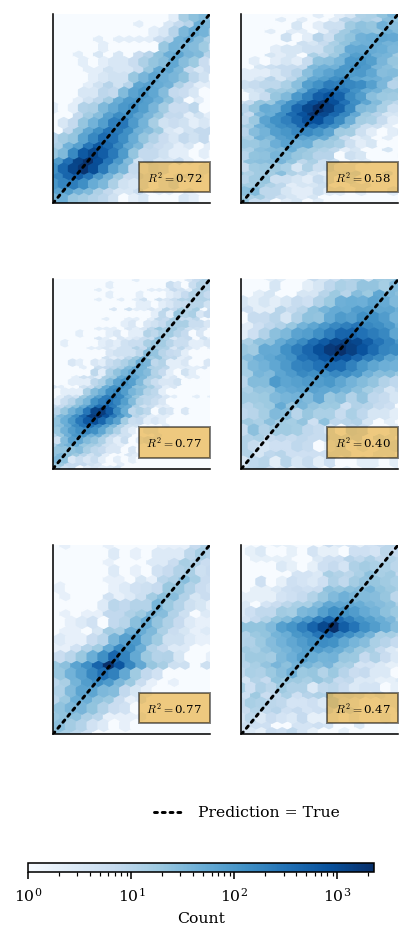

In [28]:
"""Scatter plot of deltas"""


def my_formatter(x, pos):
    if abs(x - int(x))< np.finfo(np.float32).eps:
        return str(int(x))
    else:
        return str(np.around(x,3))
#         if x<0:
#             return str(x)[:6]
#         else:
#             return str(x)[:5]

formatter = matplotlib.ticker.FuncFormatter(my_formatter)

profiles = ['dens','temp','rotation']#,'q_EFIT01','press_EFIT01']

scalarize_function_names=['pca_1','pca_2']
fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), figsize=(3.5,7))

for i,profile in enumerate(profiles):
    for j,name in enumerate(scalarize_function_names):

        pred=copy.deepcopy(all_predicted[profile][name]-all_inp[profile][name])
        true=copy.deepcopy(all_true[profile][name]-all_inp[profile][name])

        ax = axes[i,j]
#         if name in ['Mean','Std. Dev.']:
        pred *= scenario['normalization_dict'][profile]['iqr']
        true *= scenario['normalization_dict'][profile]['iqr']
        
        bounds = find_bounds(true,pred,95)
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)

        r2_model = r2_score(true,pred)
        r2_baseline = r2_score(true, np.zeros(true.shape))

        hb = ax.hexbin(true,pred,gridsize=100,bins='log',mincnt=0,cmap='Blues')
        ax.text(0.95, 0.1, '$R^2=${:.2f}'.format(r2_model), fontsize=6, horizontalalignment='right',verticalalignment='bottom', 
                transform=ax.transAxes,bbox=dict(facecolor=colorblind_colors[-1], alpha=0.5))
#         ax.text(0.95, 0.1, '$R^2=${:.2f}'.format(r2_baseline), fontsize=8, horizontalalignment='right',verticalalignment='bottom', 
#                 transform=ax.transAxes,bbox=dict(facecolor=colorblind_colors[1], alpha=0.5)) 

        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color='k', linestyle=':',lw=1.5,label='Prediction = True')
#         ax.axhline(0,color=colorblind_colors[1],lw=1.5,label='Baseline')
        if i==0:
            pass #ax.set_title(labels[profile])
        if i==0:
            pass #ax.set_title(scatter_titles[name], size=10) #8)
#         if i==len(profiles)-1:
#             ax.set_xlabel('True',size=10)
        if j in [0]:
            pass #ax.set_ylabel(labels[profile], size=20) #8)
#         if j in [1,2,3]:
#             if ylabels[i] == '$q$':
#                 ax.set_ylabel(labels[i] + ' \n Prediction', size=10)
#             else:
#                 ax.set_ylabel(labels[i] + ' (unitless) \n Prediction', size=10)
        ax.tick_params(axis='both', which='major', labelsize=6)
#         ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        ax.xaxis.set_minor_formatter(formatter)
        ax.yaxis.set_minor_formatter(formatter)
        ax.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            left=False,
            right=False,
            top=False,         # ticks along the top edge are off
            labelleft=False,
            labelbottom=False) # labels along the bottom edge are off

# axes[3,1].set_xticks([-.25,0,.25])
# axes[3,1].set_xticklabels(['-0.25','0','0.25'])
# axes[3,2].set_xticks([-.25,0,.25])
# axes[3,2].set_xticklabels(['-0.25','0','0.25'])

# axes[4,0].set_yticks([0,20000])
# axes[4,0].set_yticklabels(['0',r'2$\times 10^4$'])
# axes[4,0].set_xticks([0,20000])
# axes[4,0].set_xticklabels(['0',r'2$\times 10^4$'])

# axes[4,1].set_yticks([0,100000])
# axes[4,1].set_yticklabels(['0',r'$10^5$'])
# axes[4,1].set_xticks([0,100000])
# axes[4,1].set_xticklabels(['0',r'$10^5$'])

# axes[4,2].set_yticks([0,-10000])
# axes[4,2].set_yticklabels(['0',r'-$10^4$'])
# axes[4,2].set_xticks([0,-10000])
# axes[4,2].set_xticklabels(['0',r'-$10^4$'])

plt.subplots_adjust(hspace=0.4,wspace=0.2,bottom=0.15, left=0.2)

#fig.text(0.5, 0.1, 'True', va='center', ha='center', fontsize=10)
#fig.text(0.02, 0.5, 'Prediction', va='center', ha='center', rotation='vertical', fontsize=10)

fig.align_ylabels(axes[:,0])



cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.01])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal', fraction=.3)
cb.set_label('Count', size=8)
cb.ax.tick_params(labelsize=8)

fig.legend(handles=axes[0,0].lines,     
           labels=[line._label for line in axes[0,0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.5, 0.15),
           frameon=False,
           mode=None,
           ncol=2,
           fontsize=8);

# fig.savefig('images/all_pca_acc.pdf',bbox_inches='tight',pad_inches=0.1)
# fig.savefig('images/all_pca_acc.png',bbox_inches='tight',pad_inches=0.1)

In [17]:
"""calculate errors"""

model_err = {sig: np.abs(predictions[sig] - baseline[sig]) for sig in scenario['target_profile_names']}
baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

## Compare to other models

In [6]:
with open('/projects/EKOLEMEN/profile_predictor/run_results_time_scan/model-conv2d_profiles-dens-temp-rotation-q_EFIT01-press_EFIT01_act-target_density-pinj-tinj-curr_target-bt_22Aug20-07-05_Scenario-118_params.pkl','rb') as f:
    scenario=pickle.load(f)
# with open('/projects/EKOLEMEN/profile_predictor/run_results_time_scan/model-conv2d_profiles-dens-temp-rotation-q_EFIT01-press_EFIT01_act-target_density-pinj-tinj-curr_target-bt_22Aug20-19-09_Scenario-170_params.pkl','rb') as f:
#     scenario=pickle.load(f)    
    

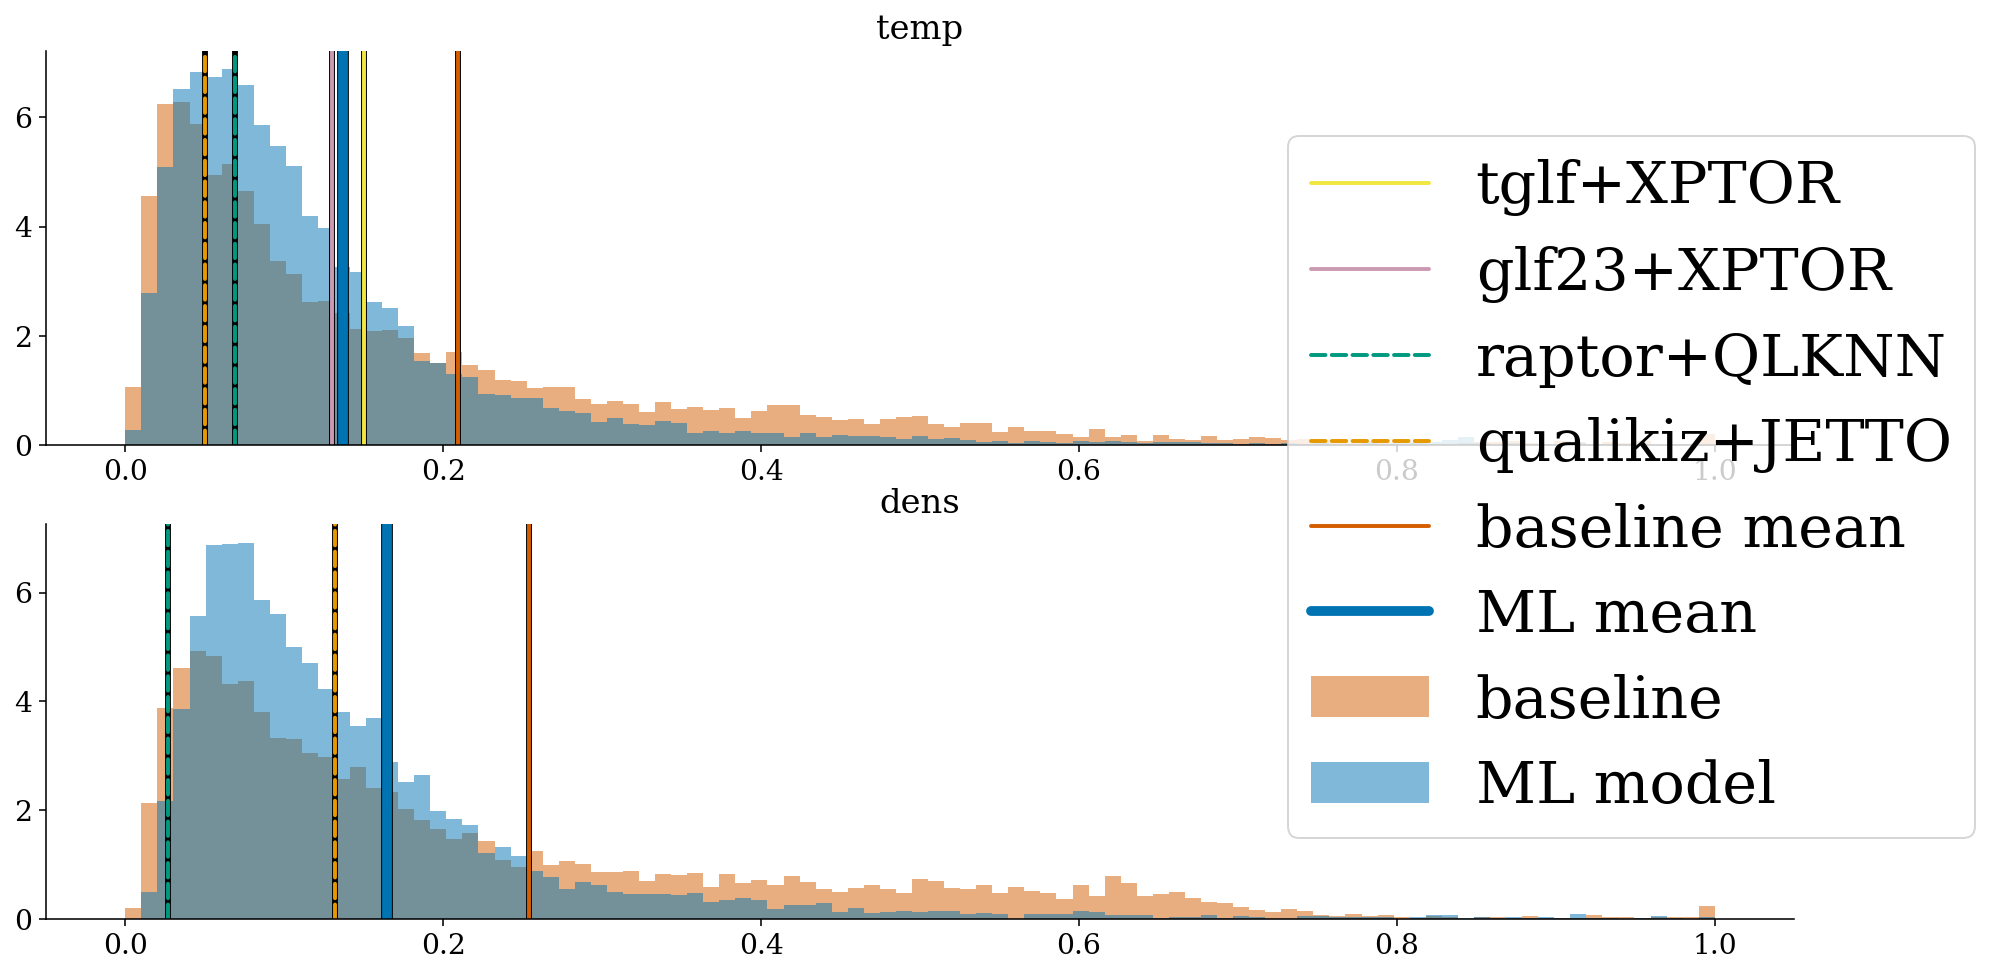

In [7]:
sigs=['temp','dens']
models=['tglf+XPTOR','glf23+XPTOR','raptor+QLKNN','qualikiz+JETTO']

model_metrics={}
model_metrics['raptor+QLKNN']={}
model_metrics['raptor+QLKNN']['dens']=.027
model_metrics['raptor+QLKNN']['temp']=.069
model_metrics['raptor+QLKNN']['color']=colorblind_colors[2]
model_metrics['raptor+QLKNN']['linetype']='--'

model_metrics['tglf+XPTOR']={}
model_metrics['tglf+XPTOR']['temp']=.15
model_metrics['tglf+XPTOR']['color']=colorblind_colors[3]
model_metrics['tglf+XPTOR']['linetype']='-'

model_metrics['glf23+XPTOR']={}
model_metrics['glf23+XPTOR']['temp']=.13
model_metrics['glf23+XPTOR']['color']=colorblind_colors[5]
model_metrics['glf23+XPTOR']['linetype']='-'

model_metrics['qualikiz+JETTO']={}
model_metrics['qualikiz+JETTO']['dens']=.132
model_metrics['qualikiz+JETTO']['rotation']=.188
model_metrics['qualikiz+JETTO']['temp']=.05
model_metrics['qualikiz+JETTO']['color']=colorblind_colors[6]
model_metrics['qualikiz+JETTO']['linetype']='--'

xlimits={'dens': [0,1], 'temp': [0,1], 'rotation': [0,1]}

fig,axes=plt.subplots(len(sigs))

#def sigma(prediction_array, full_profile_array):
#    return np.linalg.norm(prediction_array,axis=-1)/np.linalg.norm(full_profile_array,axis=-1)

def sigma(inp,true,prediction):
    eps=prediction-true
    
    num=np.linalg.norm(eps,axis=-1)
    denom=np.linalg.norm(true,axis=-1)
    
    included_inds=np.where(~np.isclose(denom,0))[0]
    return num[included_inds]/denom[included_inds]

for i,ax in enumerate(np.atleast_1d(axes)):
    sig=sigs[i]
    #baseline_sigma=sigma(inp[sig],true[sig],inp[sig])
    baseline_sigma=scenario['evaluation_metrics']['sigma_baseline_{}'.format(sig)] #sigma(inp[sig],true[sig],inp[sig])
    
    #model_sigma=sigma(inp[sig],true[sig],denormed_predictions[sig])
    model_sigma=scenario['evaluation_metrics']['sigma_ML_{}'.format(sig)] #sigma(inp[sig],true[sig],denormed_predictions[sig])
    
    ax.hist(baseline_sigma,
            bins=np.linspace(0,1,100),
            label='baseline',
            density=True,
            color=colorblind_colors[1],
            alpha=.5)

    ax.hist(model_sigma,
            bins=np.linspace(0,1,100),
            color=colorblind_colors[0],
            density=True,
            label='ML model',
            alpha=.5)

    for model in models:
        if sig in model_metrics[model]:
            ax.axvline(model_metrics[model][sig],
                      c='k',
                      linewidth=3)
            ax.axvline(model_metrics[model][sig],
                      c=model_metrics[model]['color'],
                      label=model,
                      linewidth=2,
                      linestyle=model_metrics[model]['linetype'])
    ax.axvline(np.mean(baseline_sigma),
                c='k',
                linewidth=3)
    ax.axvline(np.mean(baseline_sigma),
                c=colorblind_colors[1],
                label='baseline mean',
                linewidth=2)
    
    ax.axvline(np.mean(model_sigma),
                c='k',
                linewidth=6)
    ax.axvline(np.mean(model_sigma),
                c=colorblind_colors[0],
                label='ML mean',
                linewidth=5)
    #ax.set_xlim(xlimits[sig])
    ax.set_title(sig)
    if i==0:
        all_handles, all_labels = ax.get_legend_handles_labels()
#fig.vspace()
fig.legend(all_handles, all_labels, fontsize=30, loc='right')
plt.show()

In [ ]:
#folders = ['run_results_bt_scan']#,'run_results_06_24/', 'run_results_06_29/', 'run_results_07_16/','run_results_07_21/']
basepath='/projects/EKOLEMEN/profile_predictor/'
folders = ['run_results_time_scan']
folders = [os.path.join(basepath,folder) for folder in folders]
files=[]
for folder in folders:
    files.extend([os.path.join(folder,foo) for foo in os.listdir(folder) if '.pkl' in foo]) 

In [ ]:
mse_for_lookahead={}
mse_for_bt={}
lookahead_scenarios={}
signals=['median_squared_error',
         'temp_median_squared_error',
         'dens_median_squared_error',
         'q_EFIT01_median_squared_error',
         'press_EFIT01_median_squared_error',
         'rotation_median_squared_error']
for signal in signals:
    mse_for_lookahead[signal]={}
    mse_for_bt[signal]={}
    mse_for_bt[signal]['bt']=[]
    mse_for_bt[signal]['no bt']=[]

for f in files:
    with open(f,'rb') as f:
        scenario = pickle.load(f)
        if 'evaluation_metrics' not in scenario:
            continue
        val_ratio = abs(1-scenario['history']['val_loss'][-1]/scenario['history']['loss'][-1])
        if val_ratio < 0.05:
            for signal in signals:
                if scenario['lookahead'] not in mse_for_lookahead[signal]:
                    mse_for_lookahead[signal][scenario['lookahead']] = []
                mse_for_lookahead[signal][scenario['lookahead']].append(scenario['evaluation_metrics'][signal])
                if scenario['lookahead'] not in lookahead_scenarios:
                    lookahead_scenarios[scenario['lookahead']]=[]
                lookahead_scenarios[scenario['lookahead']].append(scenario)
                if ('bt' in scenario['actuator_names']):
                    mse_for_bt[signal]['bt'].append(scenario['evaluation_metrics'][signal])
                else:
                    mse_for_bt[signal]['no bt'].append(scenario['evaluation_metrics'][signal]) 

In [ ]:
signal_names={'median_squared_error': 'full',
             'temp_median_squared_error': 'temp',
             'dens_median_squared_error': 'dens',
             'q_EFIT01_median_squared_error': 'q',
             'press_EFIT01_median_squared_error': 'pressure',
             'rotation_median_squared_error' :'rotation'}

In [ ]:
fig, ax = plt.subplots(1,len(signals),sharey=True)

mse_dict=mse_for_lookahead

inds={this_class: np.argmin(mse_dict['median_squared_error'][this_class]) for this_class in classes}

def sigma(prediction_array, full_profile_array):
    return np.linalg.norm(prediction_array,axis=-1)/np.linalg.norm(full_profile_array,axis=-1)

classes=sorted(list(mse_dict[signals[0]].keys()))
for j,signal in enumerate(signals):
    ax[j].bar(classes,[sigma(mse_dict[signal][this_class][inds[this_class]]) for this_class in classes])
    ax[j].set_title(signal_names[signal])
    
# one for sigma, one for f, 2 bars side by side for baseline+model; but then at 1s for te have 3rd bar for tglf 

## End code for comparing models

In [19]:
"""get median and 25/75 percentile errors, denormalized, for model and baseline"""

hi_per = 75
low_per = 25

med_model_err = {sig:np.median(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_full_profile = {sig:np.median(full_profiles[sig]*scenario['normalization_dict'][sig]['iqr']
                                  + scenario['normalization_dict'][sig]['median'],axis=0) for sig in scenario['target_profile_names']}

hiper_model_err = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
hiper_baseline_err = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
hiper_full_profile = {sig:np.percentile(full_profiles[sig]*scenario['normalization_dict'][sig]['iqr']
                                         + scenario['normalization_dict'][sig]['median'],hi_per,axis=0) for sig in scenario['target_profile_names']}

lowper_model_err = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
lowper_baseline_err = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
lowper_full_profile = {sig:np.percentile(full_profiles[sig]*scenario['normalization_dict'][sig]['iqr']
                                          + scenario['normalization_dict'][sig]['median'],low_per,axis=0) for sig in scenario['target_profile_names']}

# Plot median error

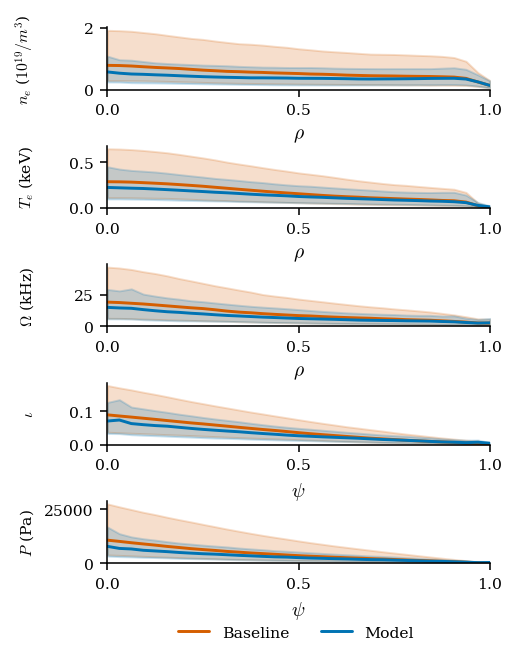

In [22]:
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']


fig, ax = plt.subplots(len(profiles),1,figsize=(3.5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline',lw=1.5)
    ax[i].fill_between(psi,lowper_baseline_err[sig],hiper_baseline_err[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model',lw=1.5)
    ax[i].fill_between(psi,lowper_model_err[sig],hiper_model_err[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[sig],size=8)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=10)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=10)

plt.subplots_adjust(hspace=0.9, bottom=0.12)
fig.align_ylabels(ax)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=8);
# fig.savefig('images/average_error.pdf',bbox_inches='tight',pad_inches=0.1)
# fig.savefig('images/average_error.png',bbox_inches='tight',pad_inches=0.1)

## Same plot but with betanfeedback on vs off

In [96]:
with open('/scratch/gpfs/jabbate/old_stuff/full_data/final_data.pkl','rb') as f:
    rawdata=pickle.load(f)

In [153]:
count_beta=0
count_nobeta=0
for shot in rawdata.keys():
    try:
        for timeind in range(len(rawdata[shot]['beam_feedback_switch'])):
            if rawdata[shot]['beam_feedback_switch'][timeind] == 2 and rawdata[shot]['beam_feedback_power_target_quantity'][timeind] == 9:
                count_beta+=1
            else:
                count_nobeta+=1
    except:
        pass

In [157]:
count_beta/(count_beta+count_nobeta)

0.2885194334510082

In [114]:
beta_inds=[]
nonbeta_inds=[]
for i in range(len(valdata['curr'])):
    time=valdata['time'][:,-scenario['lookahead']-1][i]
    shot=int(valdata['shotnum'][:,-scenario['lookahead']-1][i])
    try:
        timeind=np.argwhere(rawdata[shot]['time']==time)[0,0]
        if rawdata[shot]['beam_feedback_switch'][timeind] == 2 and rawdata[shot]['beam_feedback_power_target_quantity'][timeind] == 9:
            beta_inds.append(i)
        else:
            nonbeta_inds.append(i)
    except:
        pass

In [119]:
print(len(valdata['curr']))
print(len(beta_inds))
print(len(nonbeta_inds))

16708
2450
4938


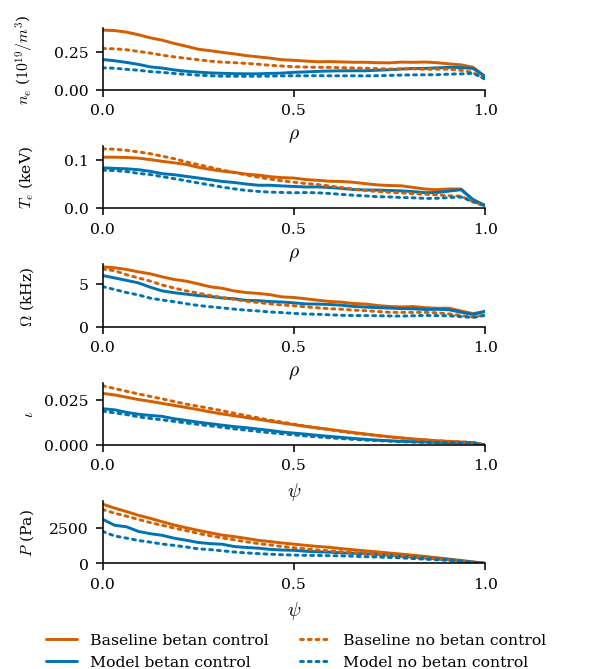

In [160]:
"""get median and 25/75 percentile errors, denormalized, for model and baseline"""

hi_per = 75
low_per = 25

#included_inds=beta_inds 
included_inds=nonbeta_inds
#included_inds=list(range(len(valdata['curr'])))
inds_list=[beta_inds, nonbeta_inds] #, list(range(len(valdata['curr'])))]
inds_name_list=['betan control', 'no betan control', 'full profiles']
inds_linestyle_list=['solid','dotted','dashed']

profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
fig, ax = plt.subplots(len(profiles),1,figsize=(3.5,5))

for j, included_inds in enumerate(inds_list):
    med_model_err = {sig:np.median(model_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
    med_baseline_err = {sig:np.median(baseline_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
    med_full_profile = {sig:np.median(full_profiles[sig][included_inds]*scenario['normalization_dict'][sig]['iqr']
                                      + scenario['normalization_dict'][sig]['median'],axis=0) for sig in scenario['target_profile_names']}

    hiper_model_err = {sig:np.percentile(model_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
    hiper_baseline_err = {sig:np.percentile(baseline_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
    hiper_full_profile = {sig:np.percentile(full_profiles[sig][included_inds]*scenario['normalization_dict'][sig]['iqr']
                                             + scenario['normalization_dict'][sig]['median'],hi_per,axis=0) for sig in scenario['target_profile_names']}

    lowper_model_err = {sig:np.percentile(model_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
    lowper_baseline_err = {sig:np.percentile(baseline_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
    lowper_full_profile = {sig:np.percentile(full_profiles[sig][included_inds]*scenario['normalization_dict'][sig]['iqr']
                                              + scenario['normalization_dict'][sig]['median'],low_per,axis=0) for sig in scenario['target_profile_names']}
    
    for i, sig in enumerate(profiles):
    
        ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline {}'.format(inds_name_list[j]),lw=1.5,linestyle=inds_linestyle_list[j])
        #ax[i].fill_between(psi,lowper_baseline_err[sig],hiper_baseline_err[sig],color=colorblind_colors[1],alpha=0.2)   
        ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model {}'.format(inds_name_list[j]),lw=1.5,linestyle=inds_linestyle_list[j])
        #ax[i].fill_between(psi,lowper_model_err[sig],hiper_model_err[sig],color=colorblind_colors[0],alpha=0.2)    

for i, sig in enumerate(profiles):
    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[sig],size=8)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=10)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=10)
            
plt.subplots_adjust(hspace=0.9, bottom=0.12)
fig.align_ylabels(ax)
#fig.legend(ax[0].lines, [line._label for line in ax[0].lines], fontsize=10, loc='right')

fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.07), #06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=8);
plt.show()

In [169]:
for j, included_inds in enumerate(inds_list):
    med_model_err = {sig:np.median(model_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
    med_baseline_err = {sig:np.median(baseline_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
    med_full_profile = {sig:np.median(full_profiles[sig][included_inds]*scenario['normalization_dict'][sig]['iqr']
                                      + scenario['normalization_dict'][sig]['median'],axis=0) for sig in scenario['target_profile_names']}

    hiper_model_err = {sig:np.percentile(model_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
    hiper_baseline_err = {sig:np.percentile(baseline_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
    hiper_full_profile = {sig:np.percentile(full_profiles[sig][included_inds]*scenario['normalization_dict'][sig]['iqr']
                                             + scenario['normalization_dict'][sig]['median'],hi_per,axis=0) for sig in scenario['target_profile_names']}

    lowper_model_err = {sig:np.percentile(model_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
    lowper_baseline_err = {sig:np.percentile(baseline_err[sig][included_inds]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
    lowper_full_profile = {sig:np.percentile(full_profiles[sig][included_inds]*scenario['normalization_dict'][sig]['iqr']
                                              + scenario['normalization_dict'][sig]['median'],low_per,axis=0) for sig in scenario['target_profile_names']}
    
    print(inds_name_list[j])
    print()
    for i, sig in enumerate(profiles):
        print(sig)
        print(np.median(med_model_err[sig]/med_baseline_err[sig]))
    print()

betan control

dens
0.5945016
temp
0.7598054
rotation
0.8275013
q_EFIT01
0.6302051
press_EFIT01
0.69018275

no betan control

dens
0.6119769
temp
0.6383082
rotation
0.656649
q_EFIT01
0.5149956
press_EFIT01
0.5594635



/home/jabbate/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


# Timeslice

In [39]:
data_generator = DataGenerator(valdata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                shuffle=False,
                                sample_weights = None)

0


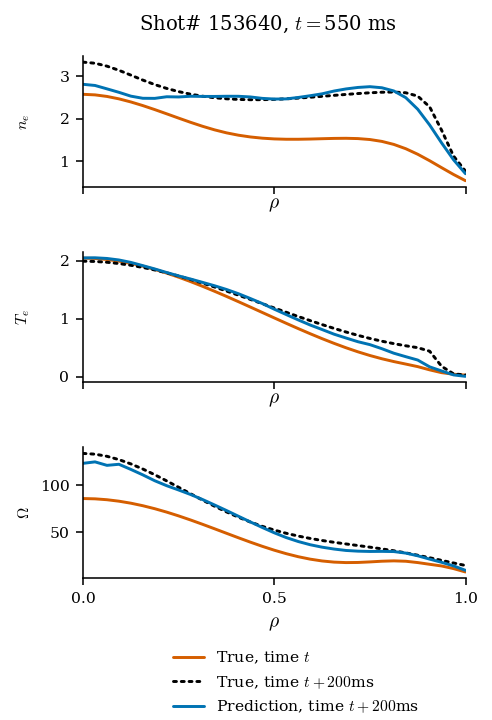

In [40]:
good_indices = [5085,8351,1749,10746,7299,479,9980,5878,1297,12951]

#index = np.random.randint(len(data_generator))
#index=7780
index=0
#index = good_indices[9]
print(index)
inputs, targets,_ = data_generator[index]
profiles = ['dens','temp','rotation']#,'q_EFIT01','press_EFIT01']

shotnum = data_generator.cur_shotnum[0,0]
shottime = data_generator.cur_times[0,-scenario['lookahead']-1]

predictions=model.predict_on_batch(inputs)
predictions = {sig: pred for sig, pred in zip(scenario['target_profile_names'],predictions)}

fig, axes = plt.subplots(len(profiles),1,sharex=True, figsize=(3.5,5))
for j, profile in enumerate(profiles):
    ax = axes[j]
    inp = inputs['input_{}'.format(profile)].squeeze()
    true = inputs['input_{}'.format(profile)].squeeze() + targets['target_{}'.format(profile)].squeeze()
    pred = inputs['input_{}'.format(profile)].squeeze() + predictions[profile].squeeze()

    inp = helpers.normalization.denormalize_arr(inp,scenario['normalization_dict'][profile])
    true = helpers.normalization.denormalize_arr(true,scenario['normalization_dict'][profile])
    pred = helpers.normalization.denormalize_arr(pred,scenario['normalization_dict'][profile])

    ax.plot(psi,inp,lw=1.5,label='True, time $t$',c=colorblind_colors[1])
    ax.plot(psi,true,lw=1.5,label='True, time $t+200$ms',c='k',ls=':')
    ax.plot(psi,pred,lw=1.5,label='Prediction, time $t+200$ms',c=colorblind_colors[0])

    ax.set_ylabel(labels[profile],size=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xticks([0,.5,1])
    ax.set_xlim(0,1)
    if j in [0,1,2]:
        ax.set_xlabel('$\\rho$',size=10)
    if j in [3,4]:
        ax.set_xlabel('$\psi$',size=10)
fig.align_ylabels(axes)
plt.subplots_adjust(top=.92, bottom=.18, hspace=0.5)
fig.suptitle("Shot# {}, $t=${} ms".format(int(shotnum), int(shottime)),fontsize=10)
fig.legend(handles=axes[0].lines,     
           labels=[line._label for line in axes[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.12),
           frameon=False,
           mode=None,
           ncol=1,
          fontsize=8)
fig.savefig('images/timeslice_{}.png'.format(index),bbox_inches='tight',pad_inches=0.1)
fig.savefig('images/timeslice_{}.pdf'.format(index),bbox_inches='tight',pad_inches=0.1)

# Phase space scatter plot

In [166]:
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl' 
with open(test_data_path,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')

In [173]:
shots = list(rawdata.keys())
nshots = len(shots)

In [192]:
def stats_1d(x):
    y = (np.nanmean(x), np.nanstd(x))
    if all(np.isfinite(y)):
        return y
    else:
        return (np.nan,np.nan)

def stats_2d(x):
    y = np.nanmean(x,axis=1)
    z = (np.nanmean(y), np.nanstd(y))
    if all(np.isfinite(z)):
        return z
    else:
        return (np.nan,np.nan)


In [196]:
sigs1d = ['pinj','tinj','target_density','gasA','curr_target']
sigs2d = ['temp','dens','rotation']
sigs = sigs1d + sigs2d
data = {sig:{'mean':np.zeros(nshots),'std':np.full(nshots,np.nan)} for sig in sigs}

for i, shot in enumerate(shots):
    if set(sigs).issubset(set(rawdata[shot].keys())):
        for sig in sigs:
            if sig in sigs1d:
                data[sig]['mean'][i], data[sig]['std'][i] = stats_1d(rawdata[shot][sig])
            elif sig in sigs2d:
                data[sig]['mean'][i], data[sig]['std'][i] = stats_2d(rawdata[shot][sig])    

/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


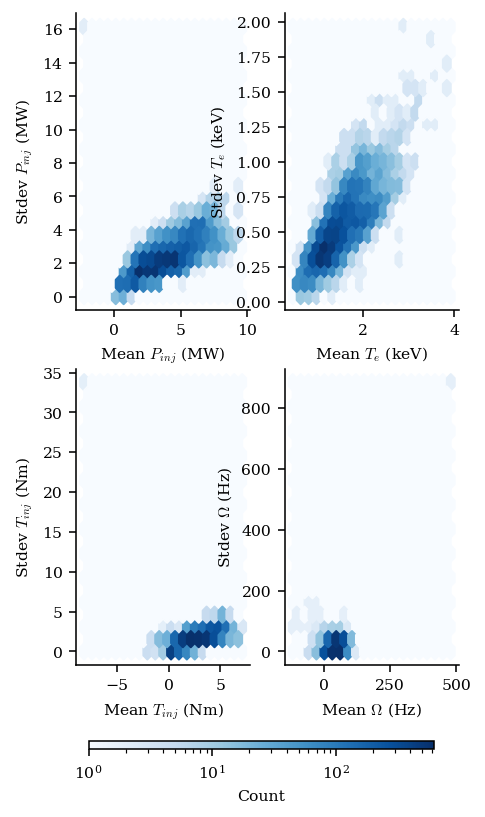

In [211]:
sig = 'temp'
fig, axes = plt.subplots(2,2,figsize=(3.5,6))

hb = axes[0,0].hexbin(data['pinj']['mean']/1000,data['pinj']['std']/1000,cmap='Blues',bins='log',mincnt=0,gridsize=20)
axes[0,0].tick_params(axis='both', which='major', labelsize=8)
axes[0,0].set_xlabel('Mean $P_{inj}$ (MW)', fontsize=8)
axes[0,0].set_ylabel('Stdev $P_{inj}$ (MW)', fontsize=8)


axes[0,1].hexbin(data['temp']['mean'],data['temp']['std'],cmap='Blues',bins='log',mincnt=0,gridsize=20)
axes[0,1].tick_params(axis='both', which='major', labelsize=8)
axes[0,1].set_xlabel('Mean $T_{e}$ (keV)', fontsize=8)
axes[0,1].set_ylabel('Stdev $T_{e}$ (keV)', fontsize=8)

axes[1,0].hexbin(data['tinj']['mean'],data['tinj']['std'],cmap='Blues',bins='log',mincnt=0,gridsize=20)
axes[1,0].tick_params(axis='both', which='major', labelsize=8)
axes[1,0].set_xlabel('Mean $T_{inj}$ (Nm)', fontsize=8)
axes[1,0].set_ylabel('Stdev $T_{inj}$ (Nm)', fontsize=8)

axes[1,1].hexbin(data['rotation']['mean'],data['rotation']['std'],cmap='Blues',bins='log',mincnt=0,gridsize=20)
axes[1,1].tick_params(axis='both', which='major', labelsize=8)
axes[1,1].set_xlabel('Mean $\Omega$ (Hz)', fontsize=8)
axes[1,1].set_ylabel('Stdev $\Omega$ (Hz)', fontsize=8)

cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.01])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal', fraction=.3)
cb.set_label('Count', size=8)
cb.ax.tick_params(labelsize=8)